# The Markov chain Monte Carlo (MCMC) method

## Markov chain Monte Carlo optimisations

Optimising or finding the minima of functions is a surprising application of the use of random numbers.  These types of simulations find use in a variety of areas of statistical physics, quantum mechanics, and strangely enough curve fitting.

The general strategy for finding the minimum of a function $F$ is the following.  We make a guess at the initial variables and compute the value of the function $F$.  Then a random walk in these variables is conducted, accepting those moves that reduce the value of F as well as some small random fluctuations to larger values of $F$.  This random walk through parameters is continued until the parameters converge and fluctuate around a fixed value.  This strategy for minimisation utilises random numbers to explore parameter values without bias, to generate fluctuations that allow the solution to escape local minima in parameter space, and provides a distribution of states around minima.

We will use a variant of the *Metropolis-Hastings* algorithm.  This type of Markov chain Monte Carlo simulation involves the following steps:
1. Choose a starting state, which we’ll call state 0.
2. *Propose* a move at random from an allowed set of moves. This would take the system from state $i$ to a new state $i+1$.
3. Calculate the value of the *acceptance probability* $P_\mathrm{a}$
$$
    P_\mathrm{a} = \begin{cases}
                 1 & \text{if}\qquad F_{i+1} < F_i  \\
                 \exp\{-\beta(F_{i+1} - F_{i})\} & \text{if}\qquad  F_{i+1} \geq F_i
          \end{cases}
$$
where $F_i$ is the value of the function $F$ at state $i$. In other words, if I find a lower value of the function, I will certainly accept the move; if I find a higher value, there is still some probability that I will accept it, depending on how much higher it is and on the value of the acceptance parameter $\beta$.
4. With probability $P_\mathrm{a}$ *accept* the proposed move, and change the state of the system to the new one; otherwise reject it, meaning the system stays in the current state for one more step of the calculation.
5. Measure the value of the quantities of interest in the current state and add it to a running sum of such measurements (or store the values of the chain and analyse them later).
6. Repeat from step 2 until the value of $F_i$ effectively converges.

This process produces a series of states of the system, or a *Markov chain* of states.

The process is a random walk through parameter space.  However, not all steps are accepted; only those that optimise our global function $F$ with some allowance for fluctuations that are controlled through the step sizes and the acceptance coefficient $\beta$.

For our simple version of this algorithm we will store all states of the system and analyse them when we are done iterating.


## A 2D function with multiple minima

Here I'll use a simple illustrative example of the method to find the minima of a 2-d function that has multiple local minima in addition to its global minimum.  
$$
  \text{func_2d}(x,y) = r^2 \bigg(1 - \tfrac{1}{2}\sin^2 \left( \frac{\pi r}{5} \right) \bigg)
$$
where
$$
    r^2 = x^2 + y^2
$$
By inspection this function clearly has a global minimum at $(0,0)$, but due to the oscillating $\sin$ function has infinitely many other local minima, which form concentric circles in the $xy$ plane.  In general, this is a tricky problem to solve with standard approaches that can be “fooled” by local minima if we do not make an initial guess close enough.  In higher-dimensional parameter spaces visualisation becomes problematic.  So, here I use the simple 2-D function above to illustrate the method.

In [1]:
import numpy as np
from numpy.random import random, seed

import matplotlib.pyplot as plt

Text(0.5, 0, 'func_2d(x,y)')

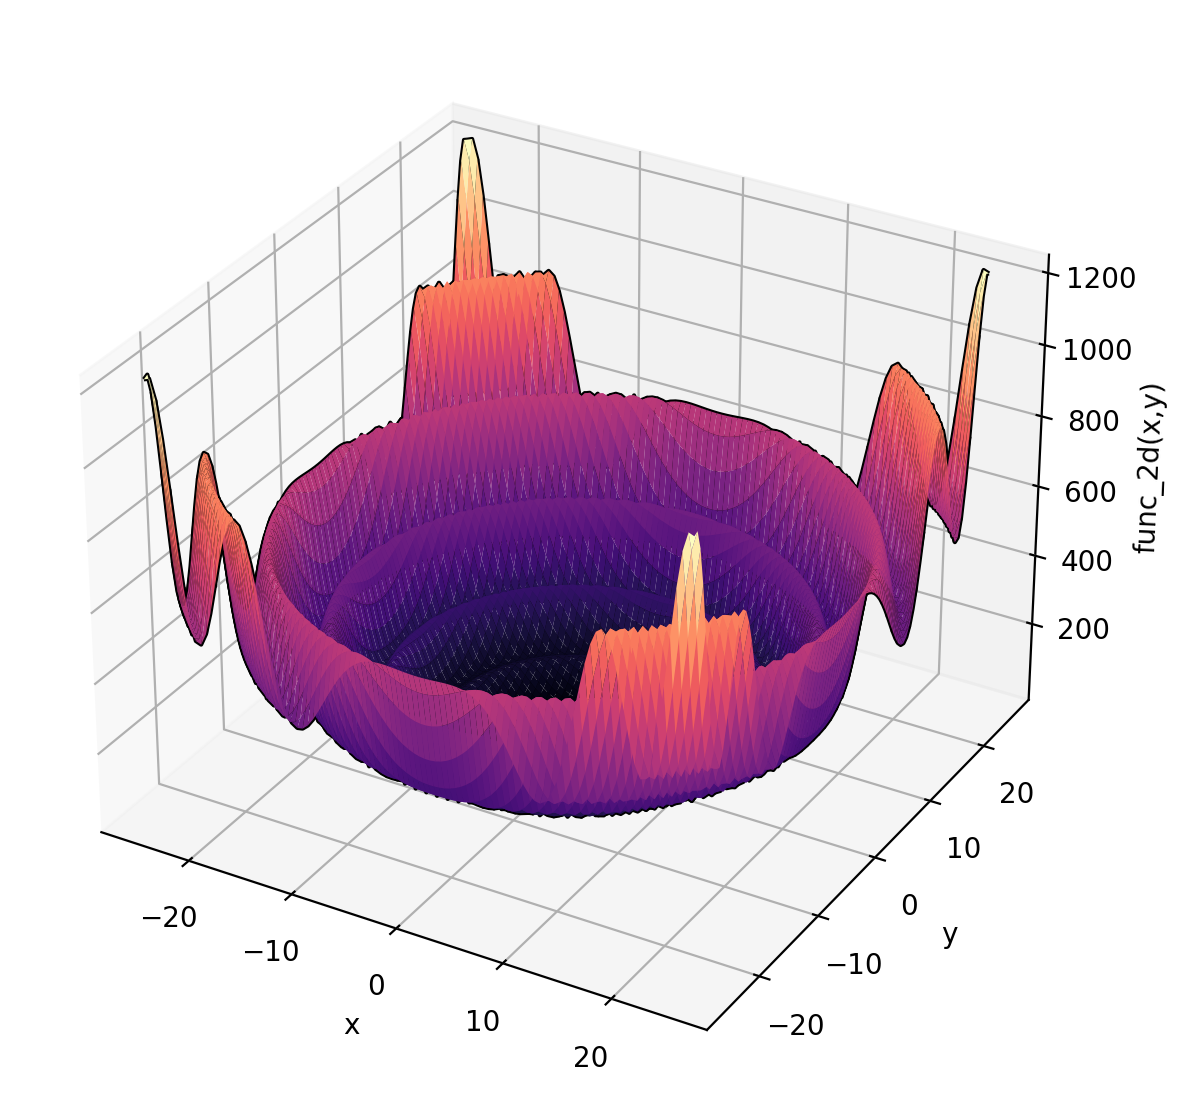

In [2]:
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import enables using projection='3d' in add_subplot s


def func_2d(x,y):
    """func2d - a mathematical function of x and y with multiple local minima
    """
    r_squared = x**2 + y**2
    return r_squared * (1 - 0.5 * np.sin(np.pi * np.sqrt(r_squared) / 5)**2)


# Code I've included to make a 3D surface plot for you

x = np.linspace(-25, 25, 100)  #  setup grid points for surface plotting
y = np.linspace(-25, 25, 100)

X, Y = np.meshgrid(x, y)

Z = func_2d(X, Y)

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(X, Y, Z, color='black')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='magma', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('func_2d(x,y)')

###  Finding the minimum of a function of more than one variable

Here we seek to minimize the function `func_2d` with respect to some parameters ($x$ and $y$ in this case).  In general, finding the minimum of a function in more than one dimension is difficult. 

I deliberately start the function off some way from the global minimum, at $x = y = 12$ which is near the second “ring” minimum. At each step I allow both $x$ and $y$ to vary by up to $\pm 1$.

Initially I will use a value of $\beta = 0.1$ and run our Markov chain for 100 000 steps.


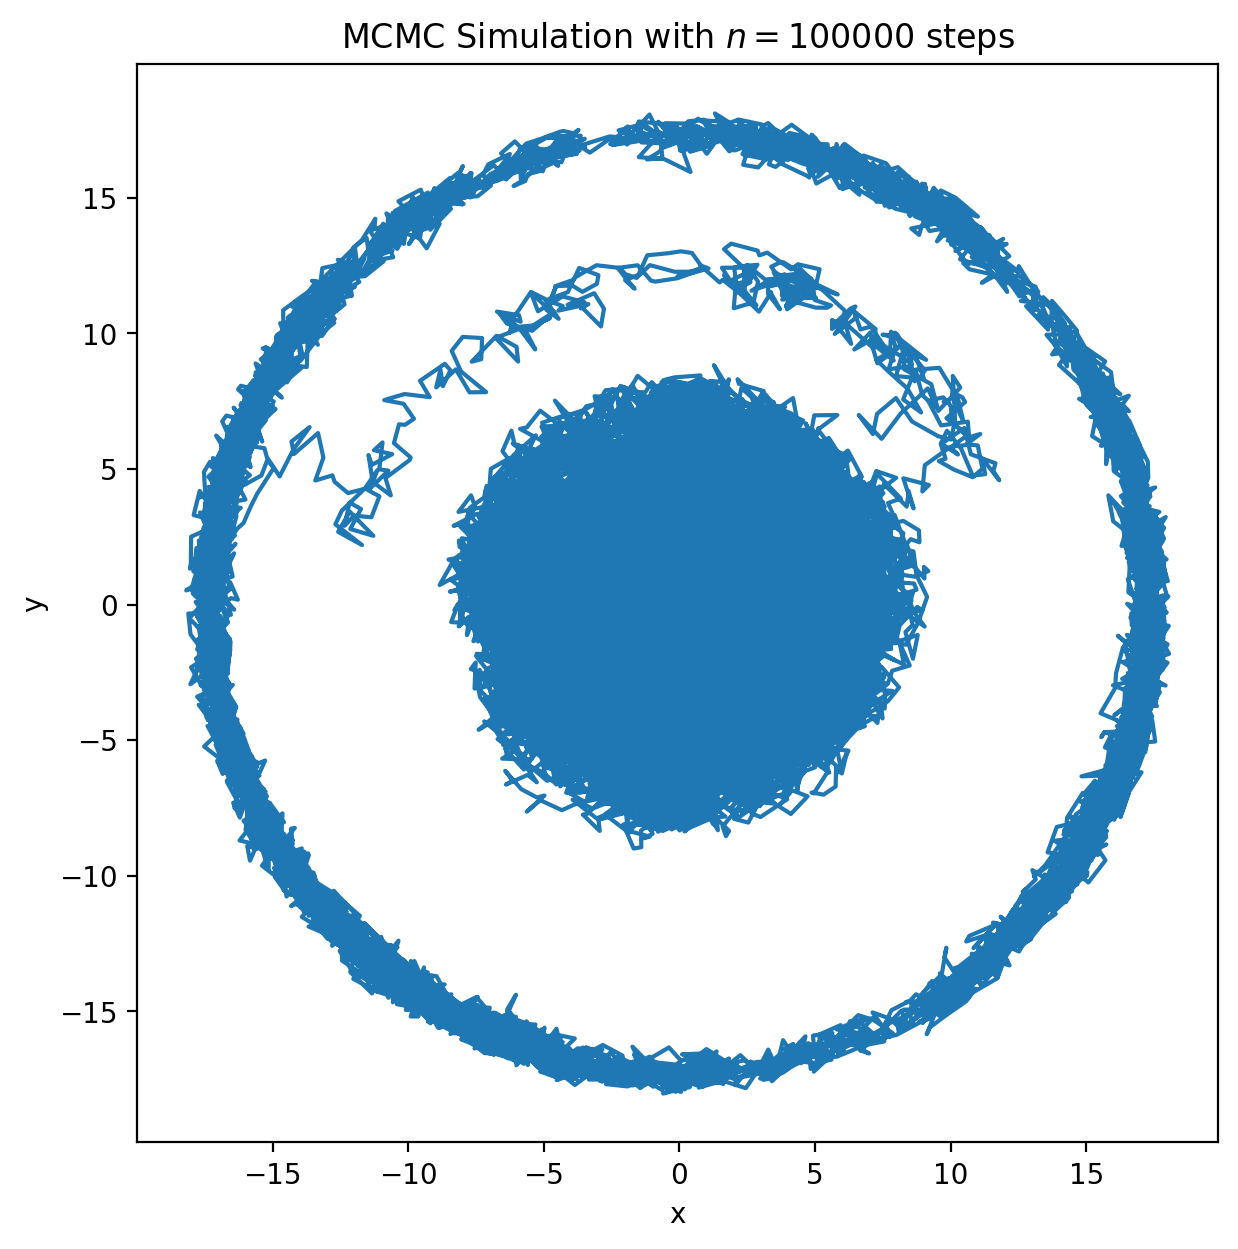

In [3]:
nsteps = 100_000
seed(5)           # random number generator seed
beta = 0.1        # acceptance parameter
step_size = 1.    # maximum step size in x and y

current_x, current_y = 12, 12 # starting position
current_F = func_2d(current_x, current_y)

x, y, F = [current_x], [current_y], [current_F]
# set up lists that we can store our path in

for i in range(nsteps):
    step = step_size * (2 * random(2) - 1) # pick a random step between -step_size and +step_size.
    # you can either do this twice, once each for x and y, or pick a random array of length 2 to start with
    new_x = current_x + step[0] # add on the x step to current_x
    new_y = current_y + step[1] # add on the y step to current_y
    new_F = func_2d(new_x, new_y)
    dF = new_F - current_F

    if dF < 0 or random() < np.exp(-beta * dF): # put the Metropolis-Hastings condition here: do we accept the "new" values or not?
        # if we do, update the "current" values to the "new" values
        current_x, current_y, current_F = new_x, new_y, new_F

    # in any case, add the "current" values to the appropriate lists
    x.append(current_x)
    y.append(current_y)
    F.append(current_F)

#plotting the walk to a solution:
plt.figure()
plt.title(f"MCMC Simulation with $n = {nsteps}$ steps")
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y)
plt.gca().set_aspect('equal')

This path taken through the parameter space – in this case the $xy$-plane – is the “chain” of states that we will analyse.

The portion of the path or chain where the state changes by large steps before finding the minimum is commonly referred to as the “burn-in”.  The parts of the chain where the solution is fluctuating about the function's minimum is referred to as 'the posterior'.  Analysing the posterior can provide information both about the coordinates in phase space (again $x-y$ in this simple example) where the minimum exists. The distribution of states as the simulation fluctuates around the minima reflect the probability distribution of possible states. 

Below I plot the value of the function against the log of the iteration number, or index of the state in the chain. I then identify the “burn in” portion of the chain and the “posterior”.

To make this *semi-log* plot, it is easiest to use `plt.semilogx()`; as always, see `?plt.semilogx()` for information on how to use this.

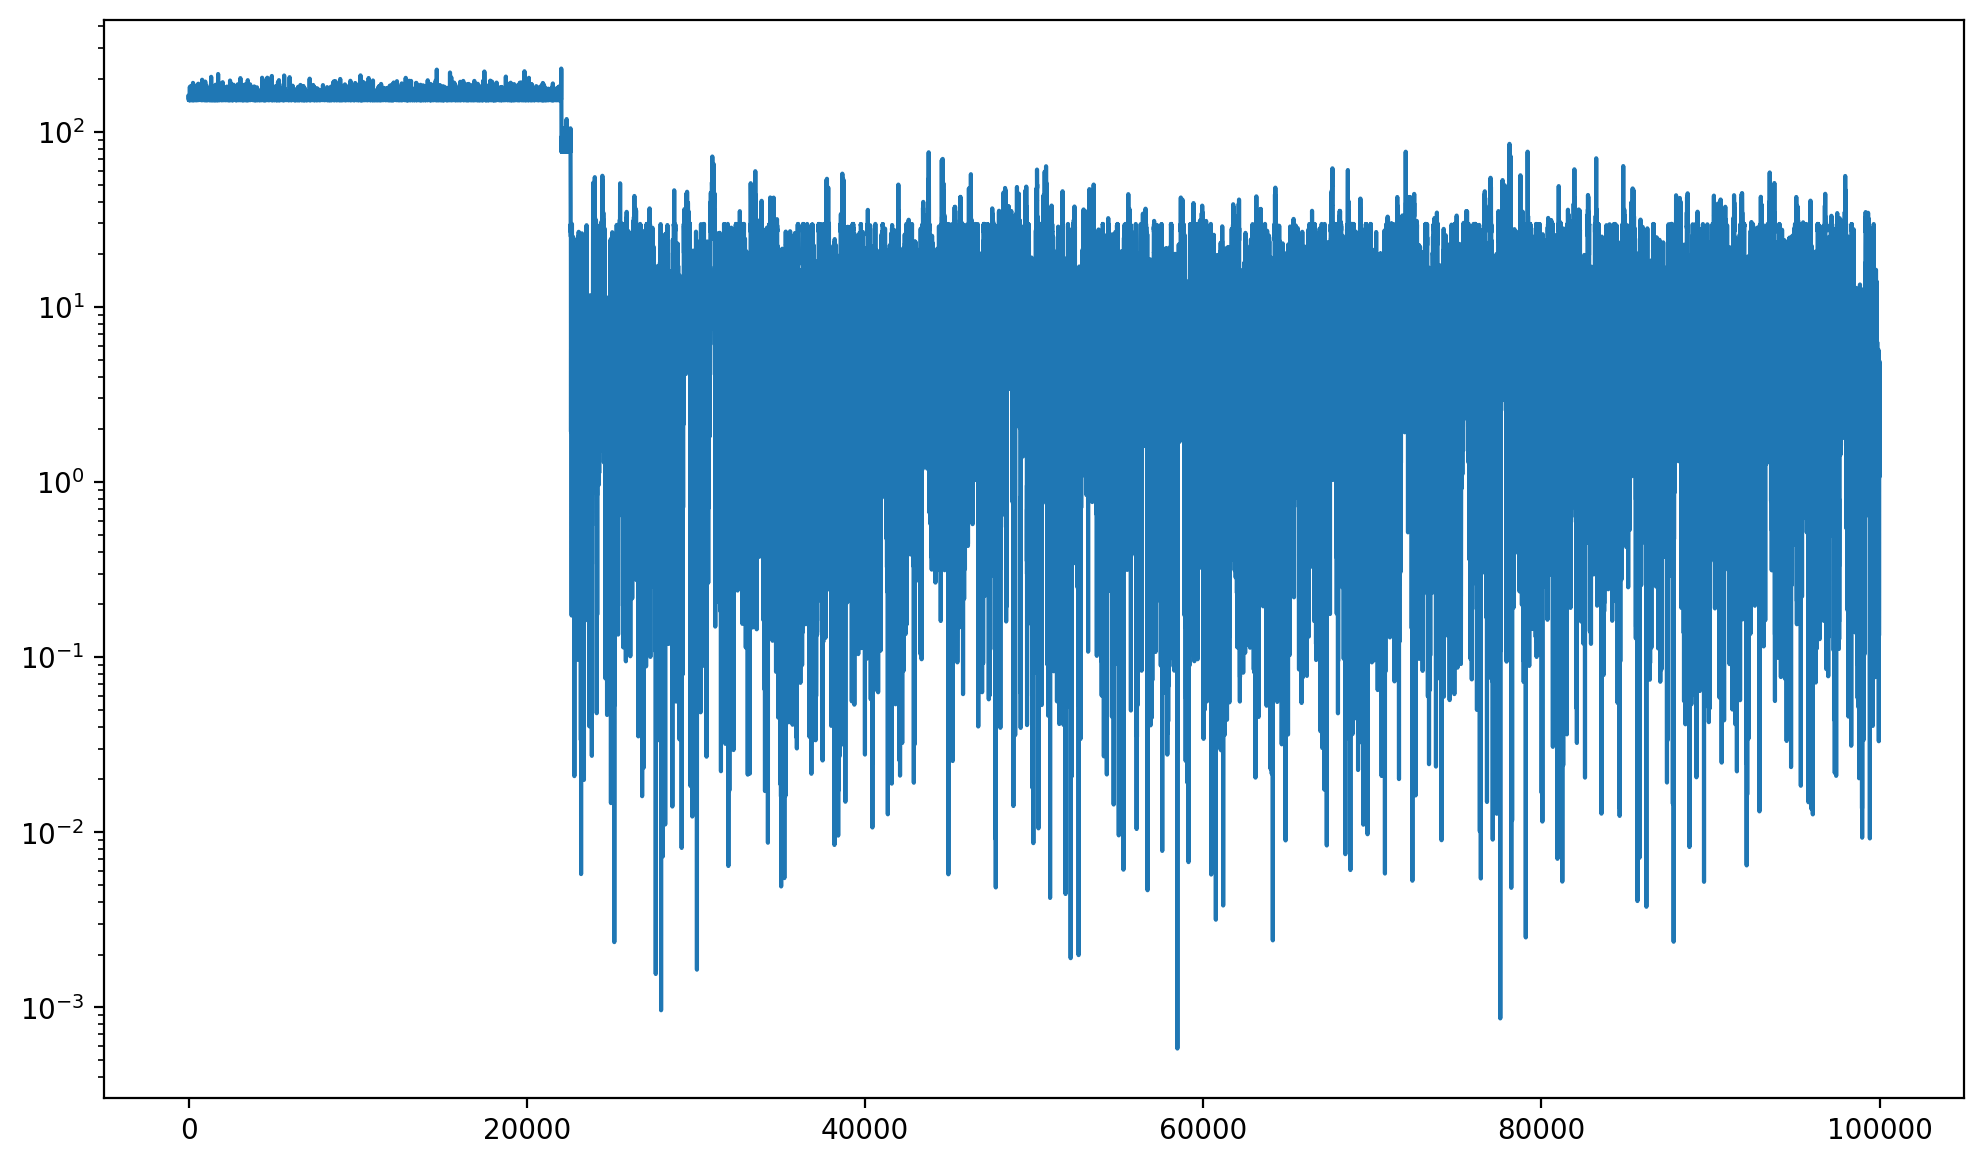

In [4]:
plt.semilogy(F)

### Isolating the posterior distribution

If my model appears to have converged to and fluctuate about a global minimum I can analyse distribution of all the states in the chain to identify a best single solution and the distribution about it.

To do this I will 'slice' off 'the burn in' phase of the chain and the first bit of 'the posterior.'

The basic requirements in slicing here are that,

- I slice far enough away from the initial state that it is forgotten in the posterior part of the chain, and

- I have enough points around the minimum to characterise the distribution there.

Using my plot of the $f(x,y)$ vs. $\log(i)$ I will identify a suitable array index to slice your chain and store the posterior in new arrays.

In [5]:
#slice data into the posterior

islice = 35_000 # choose an appropriate index here so that everything after it is posterior
xpost = x[islice:]
ypost = y[islice:]
Fpost = F[islice:]

I will now do some basic analysis on this distribution of points in the chain to characterise the optimal values (ones that find the minima in the function).

Again, I find the `np.argmin` function helpful here.

In [6]:
seed()    # if you do not use a seed, the seed is generated from the system clock!

A=random(6)
print("6 random numbers = \n ",A)
imin = np.argmin(A)
print("The minimum value is in element {:2d} and has value {:20.16f}".format(imin,A[imin]))

# or equivalently in one line
print("The minimum value is in element {:2d} and has value {:20.16f}"
      .format(np.argmin(A),np.min(A)))

6 random numbers = 
  [0.37050478 0.62526779 0.72046305 0.83136614 0.52660615 0.19556577]
The minimum value is in element  5 and has value   0.1955657676097893
The minimum value is in element  5 and has value   0.1955657676097893


Now I will find the values of $x$ and $y$ that provide the minimum value of the function.  Using nicely formatted output I will print the following:
- the values of the function at this location
- the average values of $x$ and $y$ in the posterior distribution.


In [7]:
imin = np.argmin(Fpost)
x_min = xpost[imin]
y_min = ypost[imin]
print(f"Min value of the function is {Fpost[imin]}")
print(f"\nMinimum values for x and y are => x = {x_min} and y = {y_min}")

print("\n")

average_x = np.mean(xpost)
average_y = np.mean(ypost)
print(f"Average values for x and y in the Posterior Distributions are x = {average_x} and y = {average_y}")

Min value of the function is 0.0005805975409215673

Minimum values for x and y are => x = -0.022915383766537456 and y = 0.007453138769265788


Average values for x and y in the Posterior Distributions are x = 0.07688708493788783 and y = 0.07323426596359908


### Graphical analysis of the posterior distribution

The distribution of states in the posterior portion of the chain contains statistical information about the solution.  In statistical physics simulations states reflect the distribution of states (e.g., the Maxwell-Boltzmann distribution).  In the usage here these states may reflect the uncertainty in the 'best' solution.  The distributions may also be affected by the step sizes, the acceptance conditions (e.g. $\beta$) and other aspects of the model.

Below I plot histograms of $x$ and $y$ of the posterior solution** using `plt.hist()`.

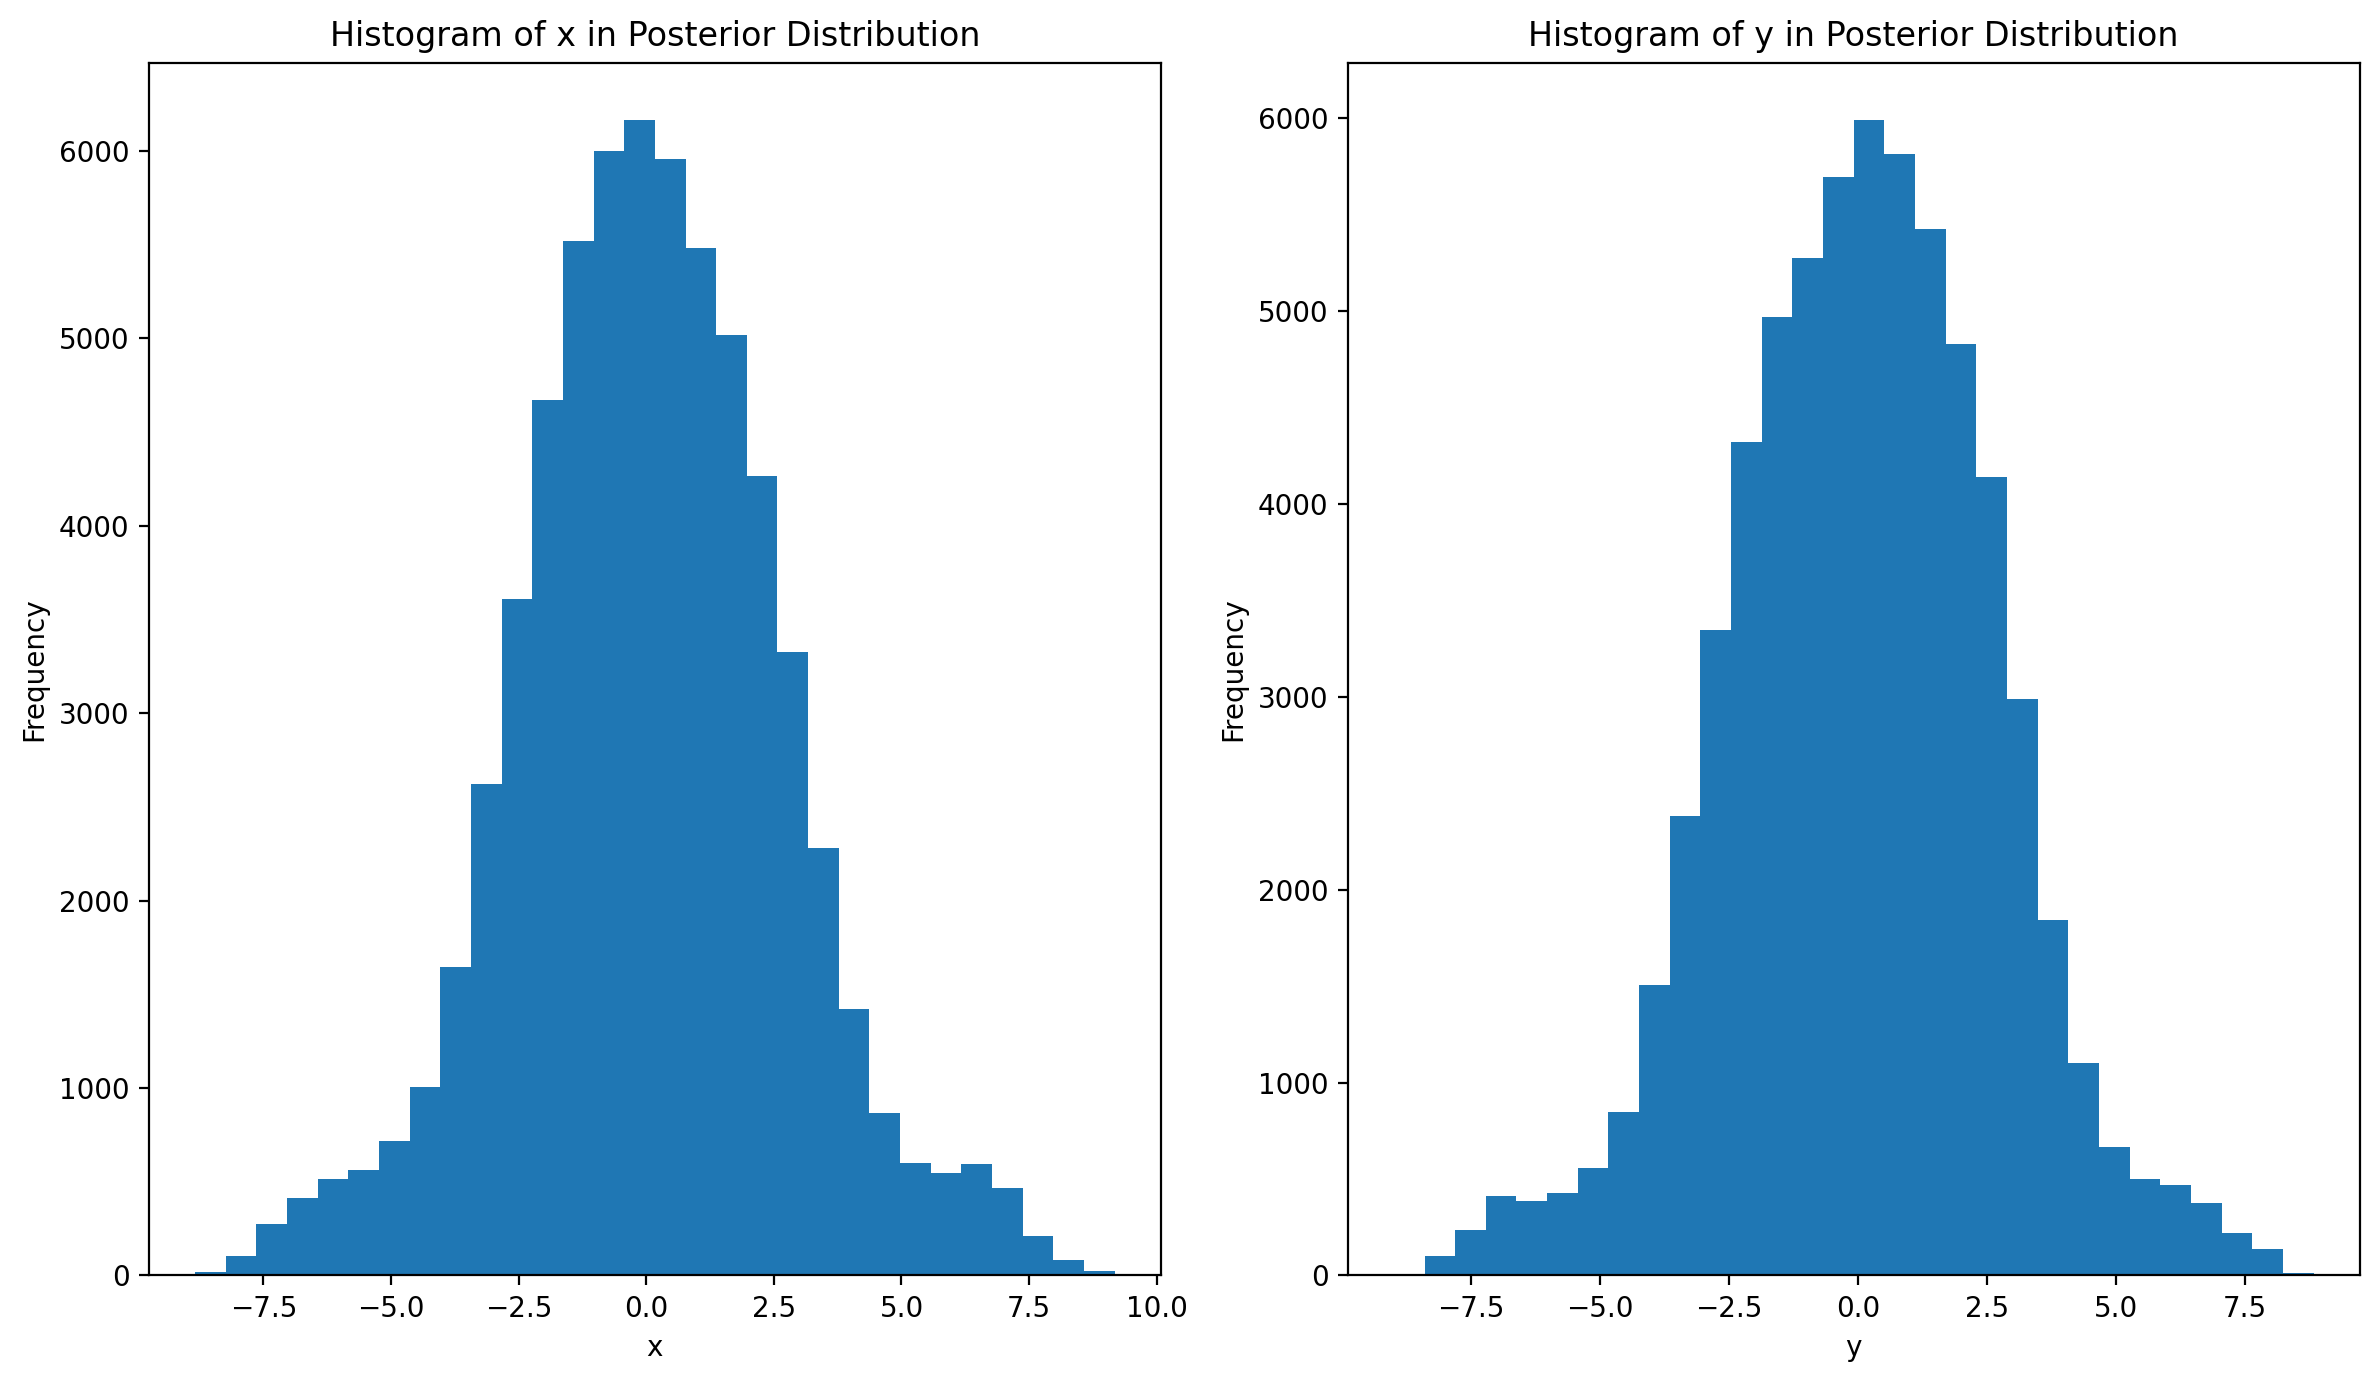

In [8]:
#plt.figure(figsize=(12,5))

# Histogram for x
plt.subplot(1, 2, 1)
plt.hist(xpost, bins=30)
plt.title('Histogram of x in Posterior Distribution')
plt.xlabel('x')
plt.ylabel('Frequency')

# Histogram for y
plt.subplot(1, 2, 2)
plt.hist(ypost, bins=30)
plt.title('Histogram of y in Posterior Distribution')
plt.xlabel('y')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

When we are optimising in more than one dimension we can also look for correlations between the 'best fit' parameters.  Here this can be done by looking at a scatter plot of the points in the posterior distribution.

In the example below the points are given a colour that is scaled with the logarithm of the function we are minimising (*i.e.*, $\log_{10}\{\text{func_2d}(x,y)\}$).  This makes it abundantly clear where the minimum is and how narrow or wide this minimum is.

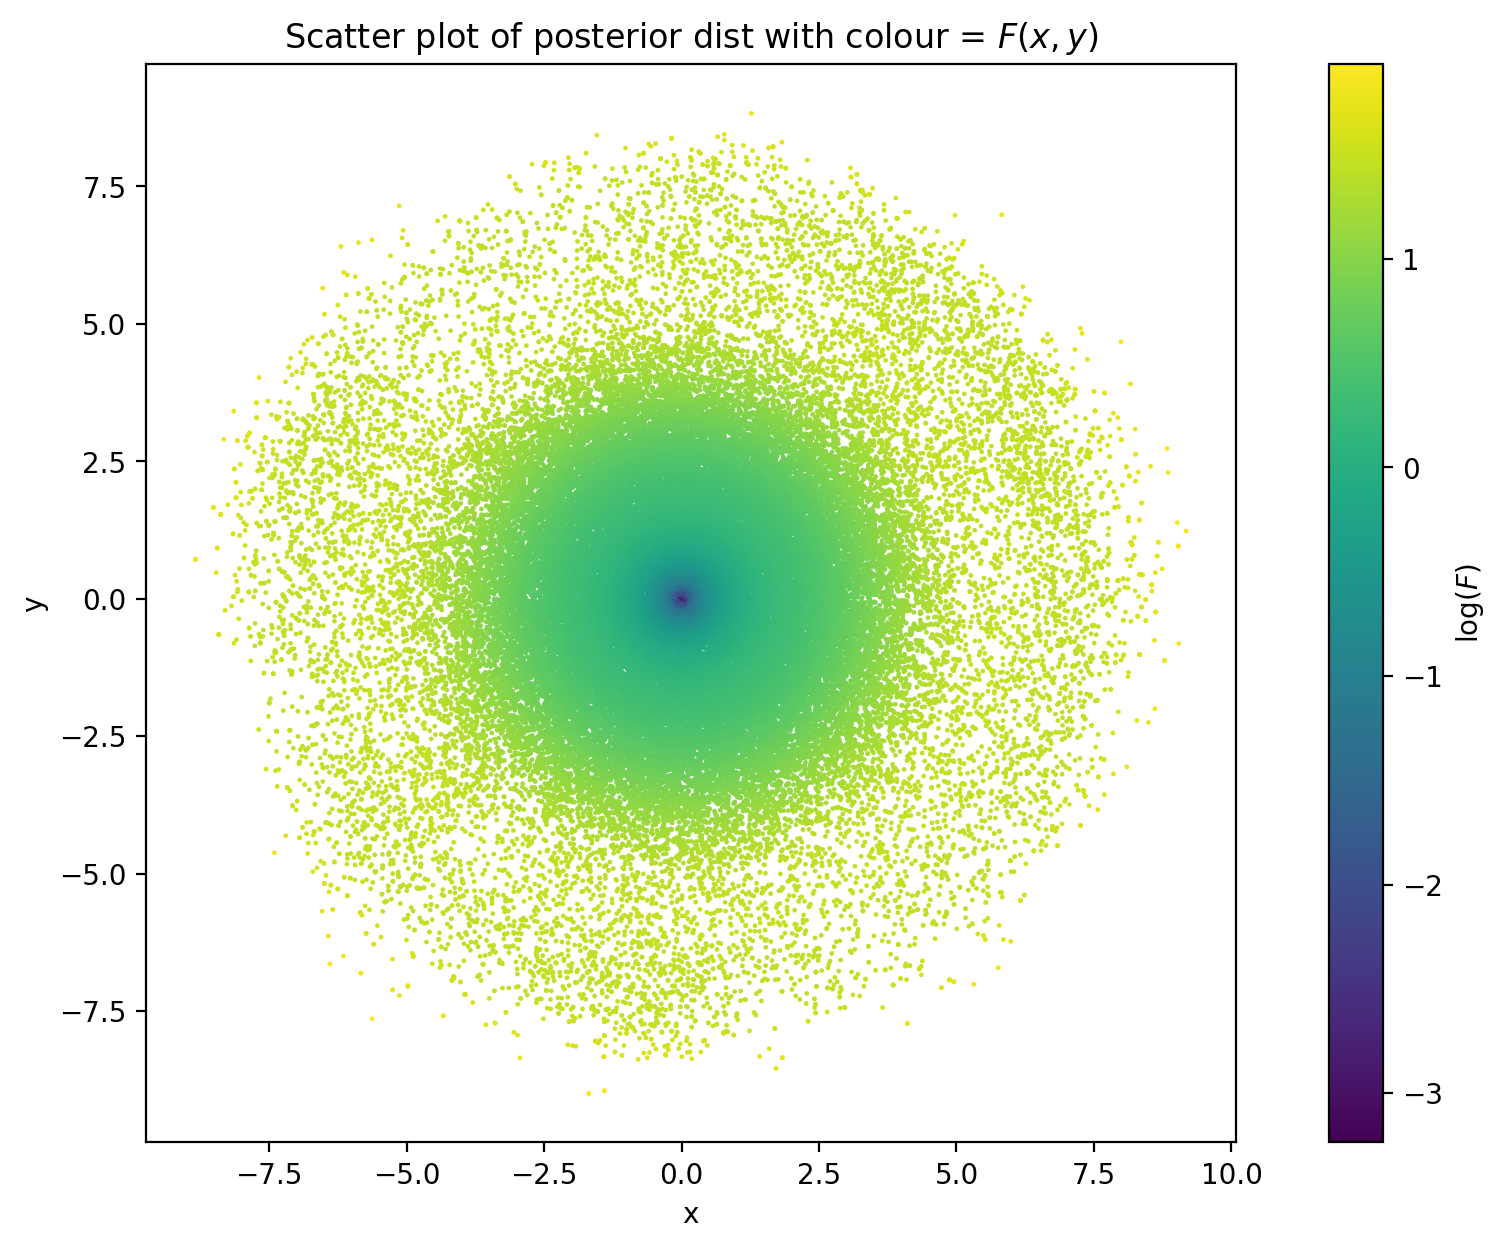

In [9]:
imin = np.argmin(Fpost)
imax = np.argmax(Fpost)

plt.figure()
plt.scatter(xpost,ypost,s=.5,
            c=np.log10(Fpost),
            vmin=np.log10(Fpost[imin]),
            vmax=np.log10(Fpost[imax]))
plt.colorbar(label='$\log(F)$')
plt.title('Scatter plot of posterior dist with colour = $F(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')

### Explore the solution

To explore the solution I will ask myself some questions such as:
* Try a few different seed values for the random number generator.  Do I obtain similar results?
* How does the solution and distribution depend on the value of $\beta$ for the same initial guess?  Try varying $\beta$ by factors of 10 larger or smaller and see how the solution changes.
* How does the solution depend on the step size of the random walk?  Try different step sizes and see how it affects the results.
* How does the solution depend on the starting point ($x,y$)?  Try different values as the starting point and see if I get different results.  My method needs to be able to “walk” to the minimum.

## Non-linear fitting with the Metropolis-Hastings MCMC method

Here we look to fit a series of observed data points with a non-linear function. This is one of the most common numerical tasks in science.  There are several different numerical approaches for obtaining a fit, including some contained in Python modules (*e.g.*, `scipy.optimize.curve_fit`).

However, since the basic operation of fitting is to reduce the norm of the residuals between a fitting function and the data points, the Metropolis minimisation algorithm described above can readily be adapted to this problem. This is particularly useful in higher-dimensional parameter spaces.  Here I’ll use a slightly unorthodox Markov Chain Monte Carlo method to explore the range of parameters that are consistent with a simulated data set.

The task I will set myself is to fit the peak in the following data set:

In [11]:
data_x = np.array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.])
data_y = np.array([10.6 , 16.  , 45.  , 83.5 , 52.8 , 19.9 , 10.8 ,  8.25,  4.7 ])
data_y_err = np.array([4., 4., 4., 4., 4., 4., 4., 4., 4.])

I will fit a *Lorentzian* peak of the form

$$
L(x) = \frac{A}{(x - x_0)^2 + \gamma^2}.
$$

The Lorenztian function is commonly used when fitting intensity as a function of wavelength to identify spectral lines.  With a proper fit, the value of $x_o$ is the wavelength of the central peak of an emmission or absorption line, $A$ is related to the intensity and $\gamma^2$ the width of the line.  So, finding best-fit values of these parameters is a way of measuring of the properties of spectral lines.

Here my fitting parameters are $\mathbf{p} = (A, x_0, \gamma^2)$ which I will represent in Python by `param = (A, x0, gammasq)`.

Below I write, the Lorentzian function:

In [12]:
def lorentzian(x, param):
    """Calculates a Lorentzian function at x with parameters param = (A, x0, gamma)."""
    A, x0, gammasq = param
    return A / ((x - x0)**2 + gammasq) # Lorentzian function here


Now I will construct a good guess at the initial parameters of $A$, $x_o$ and $\gamma^2$ that provide reasonably close fit to the data. Then I am going to plot them on top of the data. This time let’s use the `errorbar()` function to plot including error bars.

To construct a good guess, I plan to examine the function for what the different parameters do (e.g., $x_o$, $A$ and $\gamma^2$) and attempt to estimate values from your plot of the actual data. My first few trial values may be wildly incorrect, but with some experimentation I can usually find values that result in a fit that more closely follows the data.

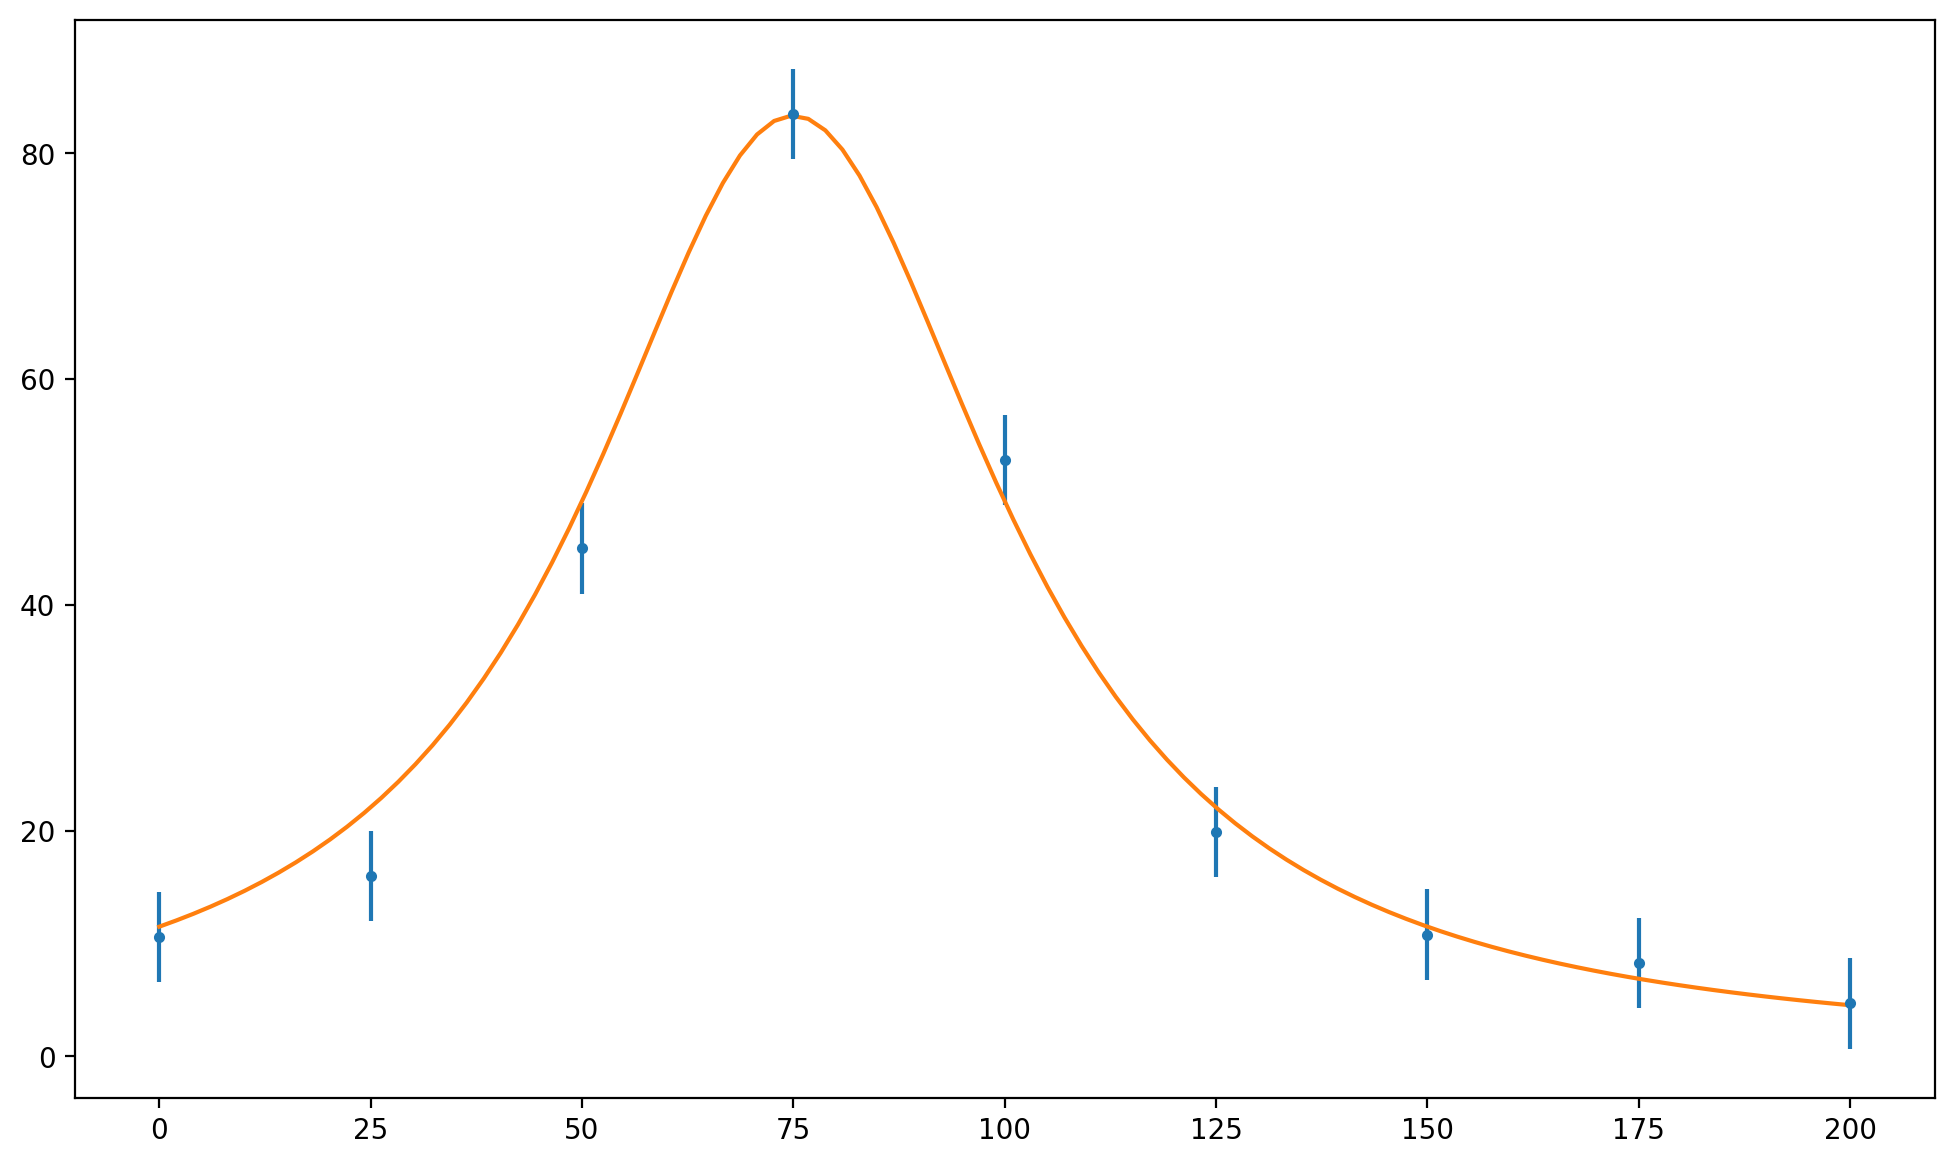

In [13]:
plt.figure()
plt.errorbar(data_x, data_y, fmt='.', yerr=data_y_err)

## not too sure on what scale the guess should be
A_guess = 75000
x0_guess = 75
gamma_sq_guess = 900
# gives different shapes

param_guess = (A_guess, x0_guess, gamma_sq_guess) # a suitable guess

xplot = np.linspace(0,200,100)
yplot = lorentzian(xplot,param_guess)

plt.plot(xplot,yplot)

### Assessing goodness of fit

I will assess the goodness of fit with some norm of the residuals.  Here I will use the weighted chi-squared function,

$$
\chi^2 = \sum_i\left( \frac{(f(x_i) - y_i)}{\sigma_i} \right)^2
$$
where $\sigma_i$ is the error in the measured $y_i$ values.

Below I am going to compute the weighted $\chi^2$ of the fit.

I will be doing this repeatedly, so it is a good idea to write a function for it.

In [15]:
def weighted_chi2(fitting_function,data,fit_params):
    data_x,data_y,data_y_err = data
    fit_y = fitting_function(data_x,fit_params)

    residuals = (fit_y - data_y) / data_y_err
    chi2 = np.sum(residuals**2)
    return chi2 # fill in the formula here

print("Weighted chi-squared = ",weighted_chi2(lorentzian,(data_x,data_y,data_y_err),param_guess))

Weighted chi-squared =  4.697339291988997


Now, I will try to improve the fit by adjust the parameters of my 'guess fit' to reduce the $\chi^2$ as much as possible.

In [16]:
from scipy.optimize import minimize

def chi2_to_minimize(params):
    return weighted_chi2(lorentzian, (data_x, data_y, data_y_err), params)

# using minimize to find params that minimize the chi2
result = minimize(chi2_to_minimize, param_guess, method='Nelder-Mead')

# getting the optimized params
optimized_params = result.x

# calculating chi2 with new optimized params
optimized_chi2 = chi2_to_minimize(optimized_params)

print(f"Optimized Parameters: {optimized_params}")
print(f"\nOptimized Weighted chi-squared: {optimized_chi2}")

Optimized Parameters: [66886.38989905    77.49357896   788.88385761]

Optimized Weighted chi-squared: 1.3166095309136268


-----------

### MCMC Metropolis Fit

Here I will use the MCMC Metropolis algorithm described to develop a better fit.  Instead of making a random walk through the $x-y$ plane as we did above, I will be 'walking' through the $A$, $x0$, $\gamma^2$ three-dimensional parameter space.

Here, each “state” is a set of $A$, $x_0$, $\gamma^2$.  The random walk will sample parameter values away from the previous state.  The function we are attempting to minimise is the $\chi^2$ function. Specifically, if the new state reduces the value of $\chi^2$ then we accept it.  If it results in an increase in $\chi^2$, we might still accept it if

$$
\text{random()}  < \exp\{-\beta(\chi^2_{i}-\chi^2_{i-1})\},
$$
where $i$ indicates the proposed state and $i-1$ the previous one.


Using the code above for minimizing `func_2d` above as a guide, I will adapt the code so that it takes random steps through the three-dimensional parameter space. The maximum step size for each parameter will be a separately adjustable parameter.

In practice, the step needs to be large enough to change the $\chi^2$ value enough to keep the random walk moving.  In other words, if the step size is too small, we don't walk far enough to find the global minimum.


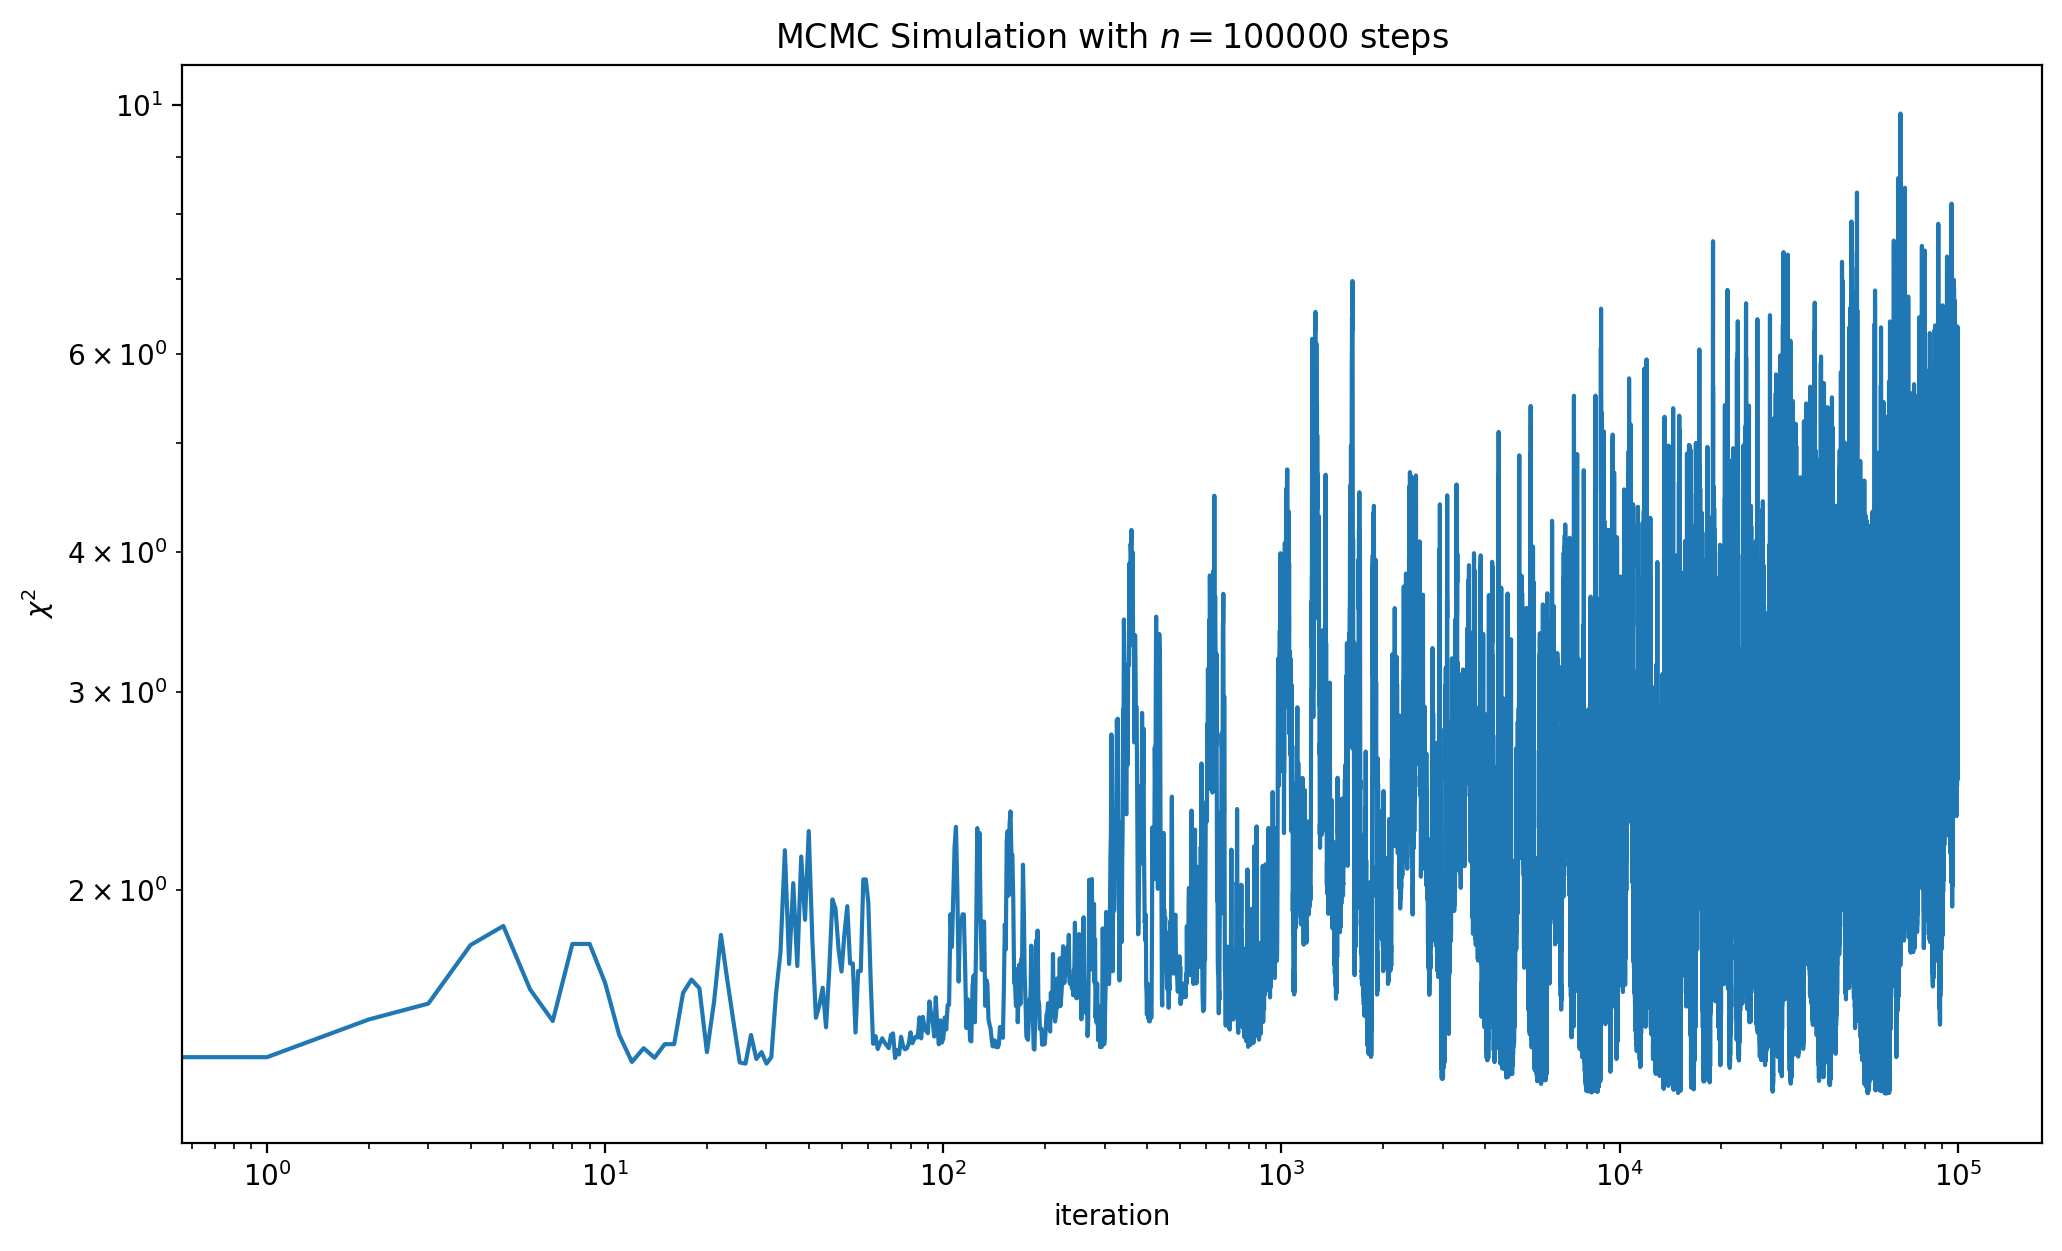

In [17]:
nsteps = 100_000
seed(1)           # random number generator seed
beta = 1          # acceptance parameter

# The step size in each parameter 
# You will need to adjust these and see how they affect the solution
# They need not all be the same size, indeed different sizes may work best.

A_step_size = 100
x0_step_size = 0.5
gammasq_step_size = 1

# the data we're fitting
data = (data_x,data_y,data_y_err)

# initial guesses
current_A =  69000
current_x0 = 77
current_gammasq = 819

current_chisq = weighted_chi2(lorentzian,data,(current_A, current_x0, current_gammasq))

A, x0, gammasq, chisq = [current_A], [current_x0], [current_gammasq], [current_chisq]

for i in range(nsteps):
    A_step = random() * 2 * A_step_size - A_step_size
    x0_step = random() * 2 * x0_step_size - x0_step_size
    gammasq_step = random() * 2 * gammasq_step_size - gammasq_step_size

    new_A = current_A + A_step
    new_x0 = current_x0 + x0_step
    new_gammasq = current_gammasq + gammasq_step

    new_chisq = weighted_chi2(lorentzian,data,(new_A, new_x0, new_gammasq))

    dchisq = new_chisq - current_chisq

    if dchisq < 0 or random() < np.exp(-beta * dchisq):
        current_A = new_A
        current_x0 = new_x0
        current_gammasq = new_gammasq
        current_chisq = new_chisq

    A.append(current_A)
    x0.append(current_x0)
    gammasq.append(current_gammasq)
    chisq.append(current_chisq)


#plot chi-squared vs iteration number:
plt.figure()
plt.title(f"MCMC Simulation with $n = {nsteps}$ steps")
plt.xlabel('iteration')
plt.ylabel('$\chi^2$')
plt.loglog(chisq)

### Graphical analysis of the posterior

Using the plot above, I am going to identify the place to slice and examine the properties of the posterior.

Now, with nicely formatted output, I will print the values of the fitting parameters ($A$, $x_o$, and $\gamma^2$) that minimise $\chi^2$ and provide the best fit.

In [18]:
#slice data into the posterior

islice = 35000
A_post = A[islice:]
x0_post = x0[islice:]
gammasq_post = gammasq[islice:]
chisq_post = chisq[islice:]

imin = np.argmin(chisq_post)

# Extract the param values that minimize chi_squared
best_A = A_post[imin]
best_x0 = x0_post[imin]
best_gammasq = gammasq_post[imin]

print(f"Best-fit Parameters are as follows:")
print(f"A: {best_A}")
print(f"x0: {best_x0}")
print(f"gamma^2: {best_gammasq}")
print(f"Minimum chi-sqaured: {chisq_post[imin]}")


Best-fit Parameters are as follows:
A: 66887.48387442926
x0: 77.47705812522645
gamma^2: 788.7416584544108
Minimum chi-sqaured: 1.3167518941097212


A useful aspect of the posterior distribution is that it can illustrate how large a region of parameter space around the minimum provides a similar solution (e.g., value of $\chi^2$).  This can be used to estimate the uncertainties in the optimising or fitting parameters.

Here I will make a histogram of the posterior distribution of each of the fitting parameters.

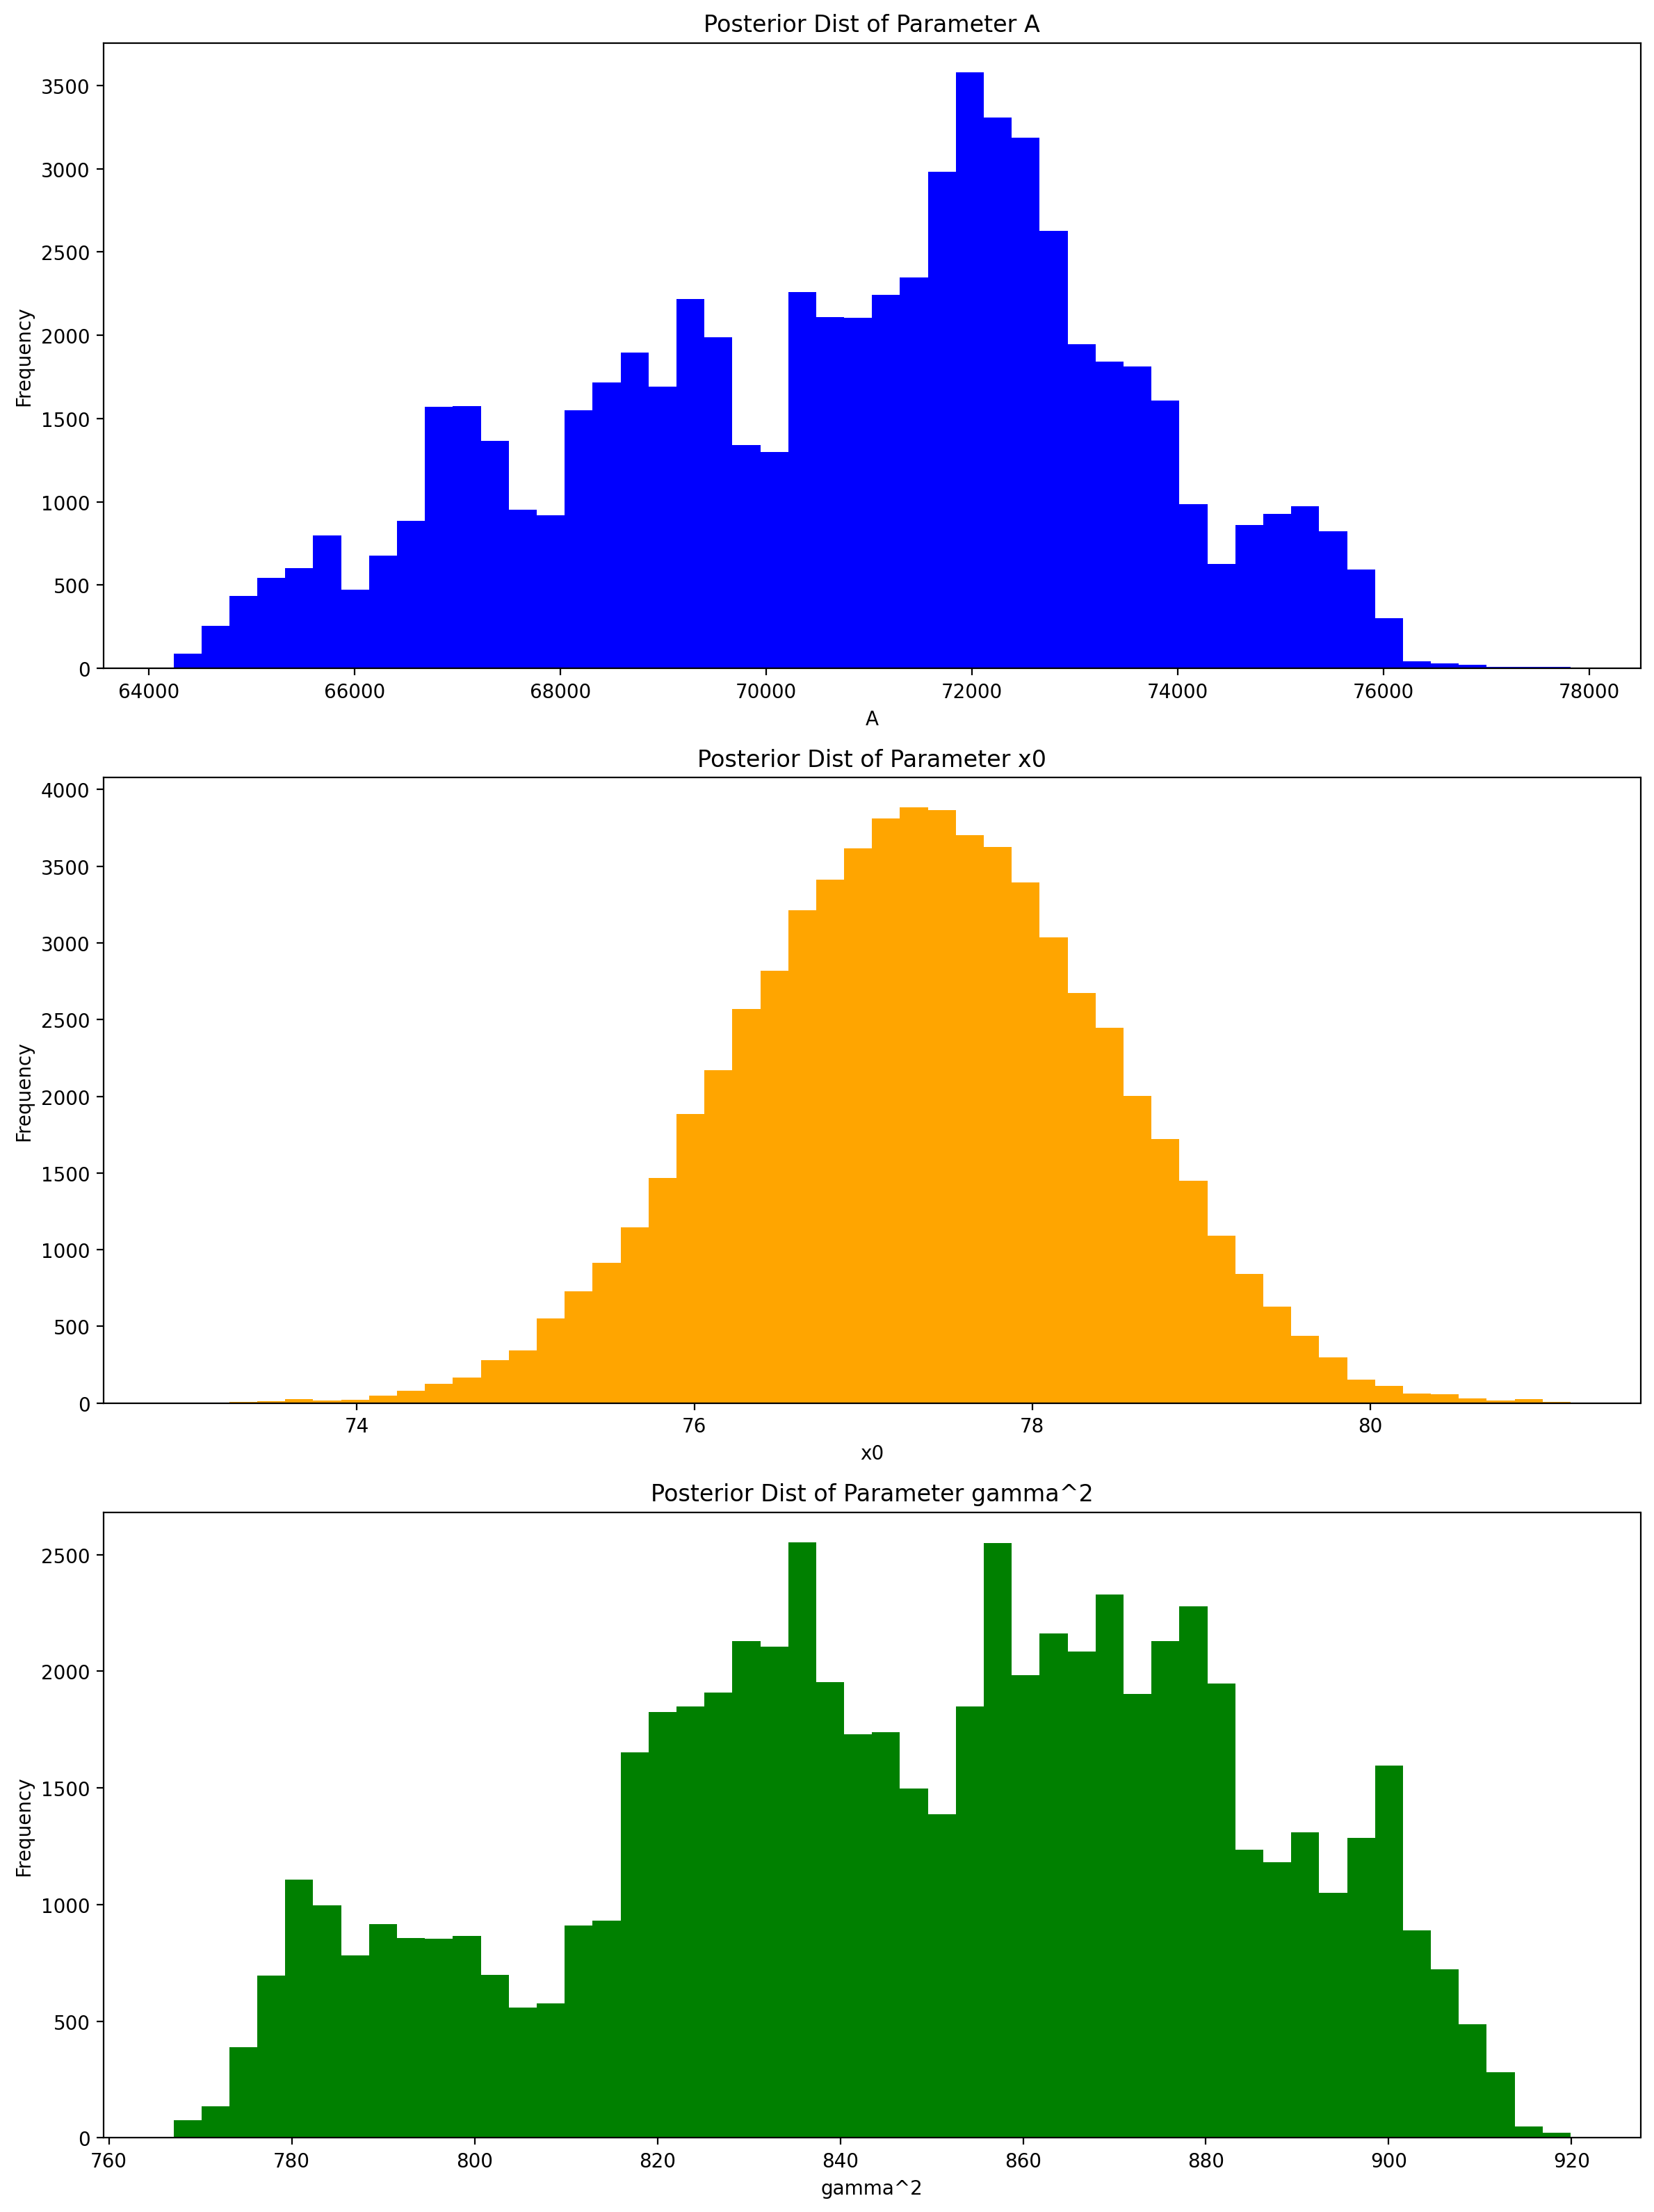

In [19]:
plt.figure(figsize=(12, 16))

plt.subplot(3, 1, 1)
plt.hist(A_post, bins=50, color='blue')
plt.title('Posterior Dist of Parameter A')
#plt.axvline(x=best_x0)
plt.xlabel('A')
plt.ylabel('Frequency')
#plt.legend()

plt.subplot(3, 1, 2)
plt.hist(x0_post, bins=50, color='orange')
plt.title('Posterior Dist of Parameter x0')
plt.xlabel('x0')
plt.ylabel('Frequency')
#plt.legend()

plt.subplot(3, 1, 3)
plt.hist(gammasq_post, bins=50, color='green')
plt.title('Posterior Dist of Parameter gamma^2')
plt.xlabel('gamma^2')
plt.ylabel('Frequency')
#plt.legend()

plt.tight_layout()
plt.show()

It is often useful to summarise these posterior distributions by *summary statistics*. The most commonly used are the mean and standard deviation. However, these are most relevant when a distribution is approximately normal (Gaussian). A more general method is to present a *confidence interval*: that is, the range of values of a parameter that we’re (say) 95% sure the true value lies within. 

To do this in `numpy`, we use the `quantile` function. For instance, `np.quantile(A_post, 0.025)` will return a value greater than 2.5% of the values in the posterior distribution of $A$. Repeat this with the 97.5% percentile and you get the 95% confidence interval: the range containing 95% of the posterior distribution.

**Here I use this function to estimate the 95% confidence interval for each of the fitting parameters.**

In [20]:
# 95% confidence interval for param A
confidence_interval_A = np.quantile(A_post, [0.025, 0.975])

# 95% confidence interval for param x0
confidence_interval_x0 = np.quantile(x0_post, [0.025, 0.975])

# 95% confidence interval for param gammasq
confidence_interval_gammasq = np.quantile(gammasq_post, [0.025, 0.975])

print("95% Confidence Interval for Parameter A:", confidence_interval_A)
print("95% Confidence Interval for Parameter x0:", confidence_interval_x0)
print("95% Confidence Interval for Parameter gammasq:", confidence_interval_gammasq)

95% Confidence Interval for Parameter A: [65497.54944151 75439.98912433]
95% Confidence Interval for Parameter x0: [75.21714419 79.41509639]
95% Confidence Interval for Parameter gammasq: [780.35254893 904.35668355]


Another useful way of analysing MCMC posterior distributions is to identify any correlations between parameter values.

**Below I will make scatter plots of $A$ vs $x_o$, $A$ vs $\gamma^2$, and $x_o$ vs $\gamma^2$.**

Text(0, 0.5, '$x_o$')

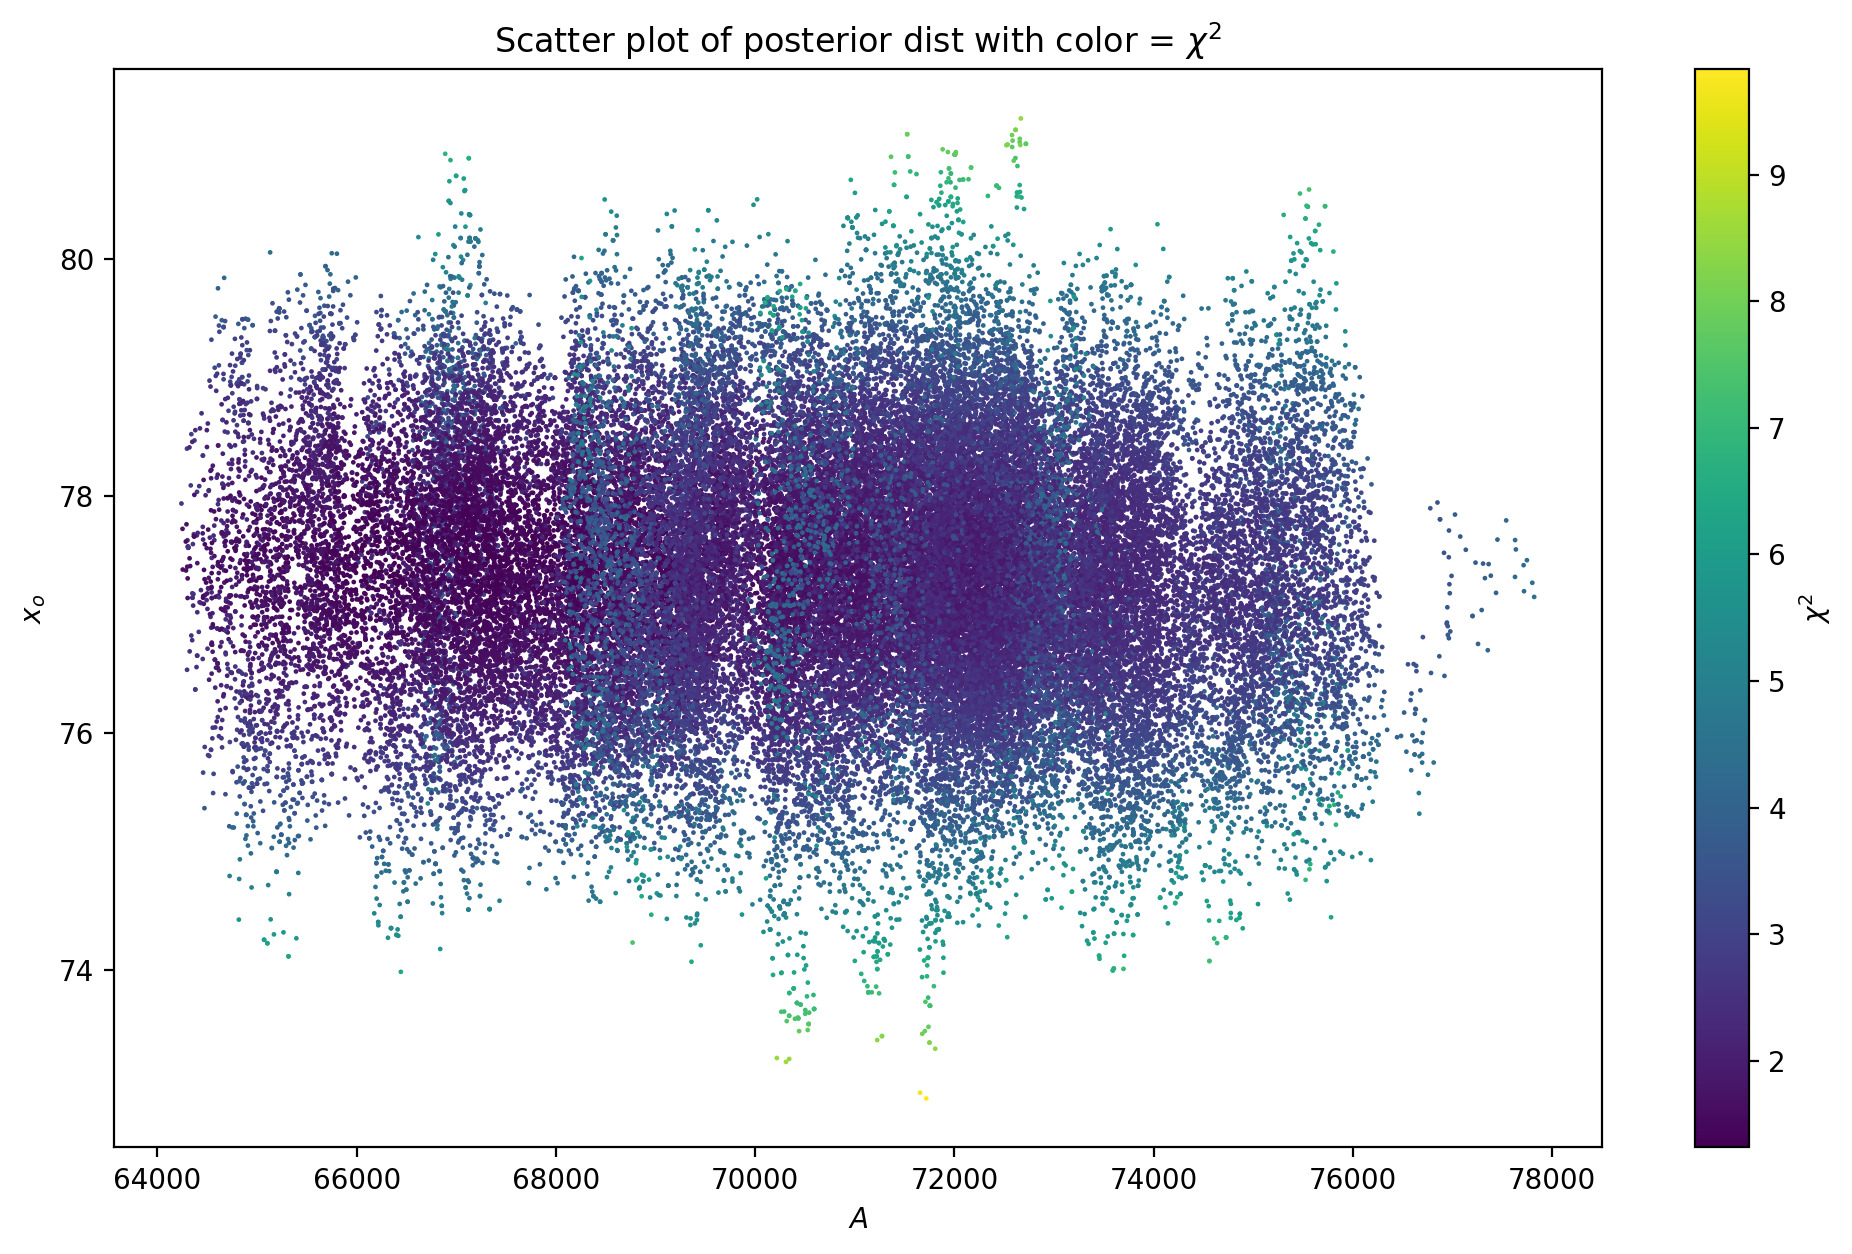

In [21]:
imin = np.argmin(chisq_post)
imax = np.argmax(chisq_post)

plt.figure()
plt.scatter(A_post,x0_post,s=.5,
            c=chisq_post,
            vmin=chisq_post[imin],
            vmax=chisq_post[imax])
plt.colorbar(label='$\chi^2$')
plt.title('Scatter plot of posterior dist with color = $\chi^2$')
plt.xlabel('$A$')
plt.ylabel('$x_o$')


Text(0, 0.5, '$\\gamma^2$')

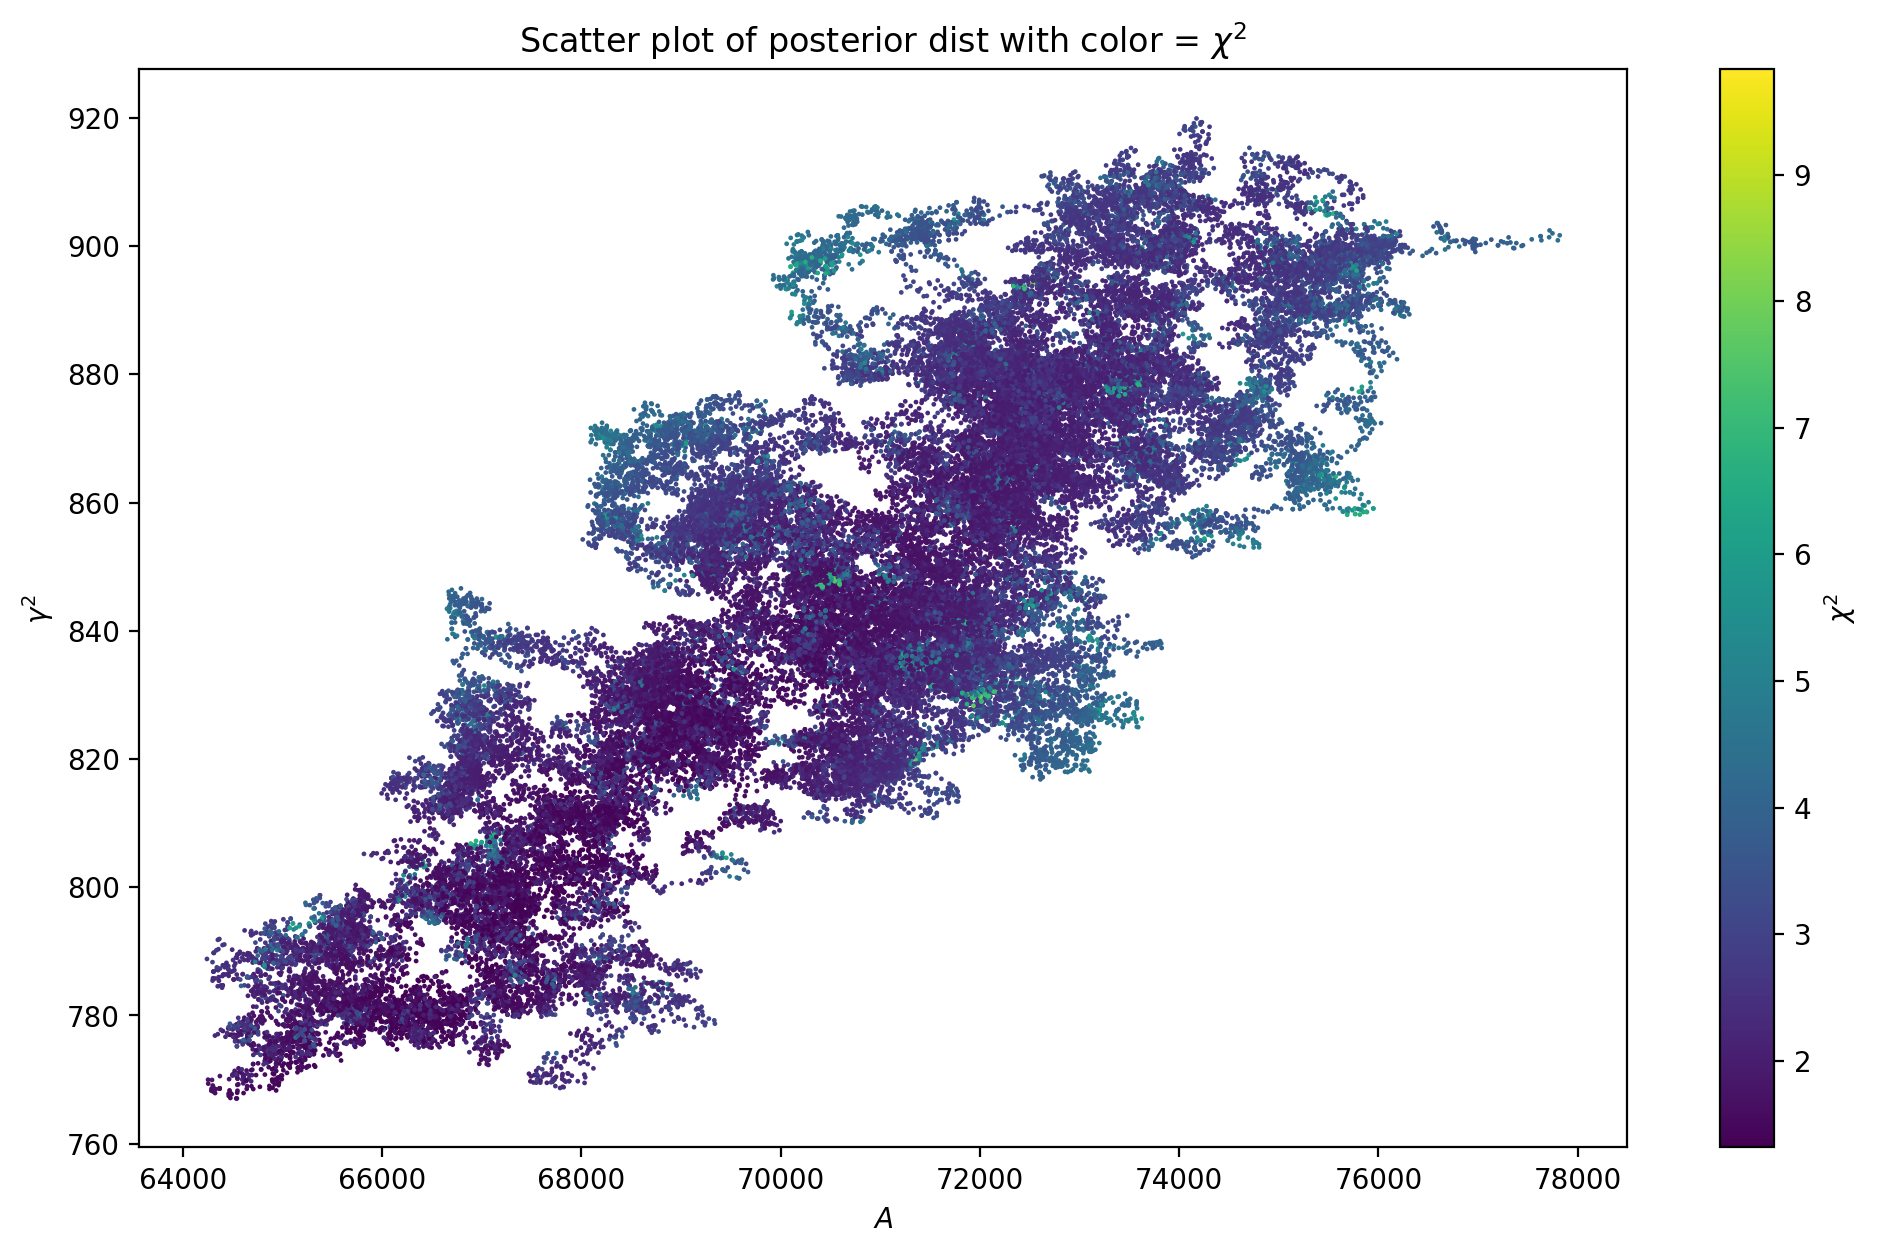

In [22]:
imin = np.argmin(chisq_post)
imax = np.argmax(chisq_post)

plt.figure()
plt.scatter(A_post,gammasq_post,s=.5,
            c=chisq_post,
            vmin=chisq_post[imin],
            vmax=chisq_post[imax])
plt.colorbar(label='$\chi^2$')
plt.title('Scatter plot of posterior dist with color = $\chi^2$')
plt.xlabel('$A$')
plt.ylabel('$\gamma^2$')

Text(0, 0.5, '$x_o$')

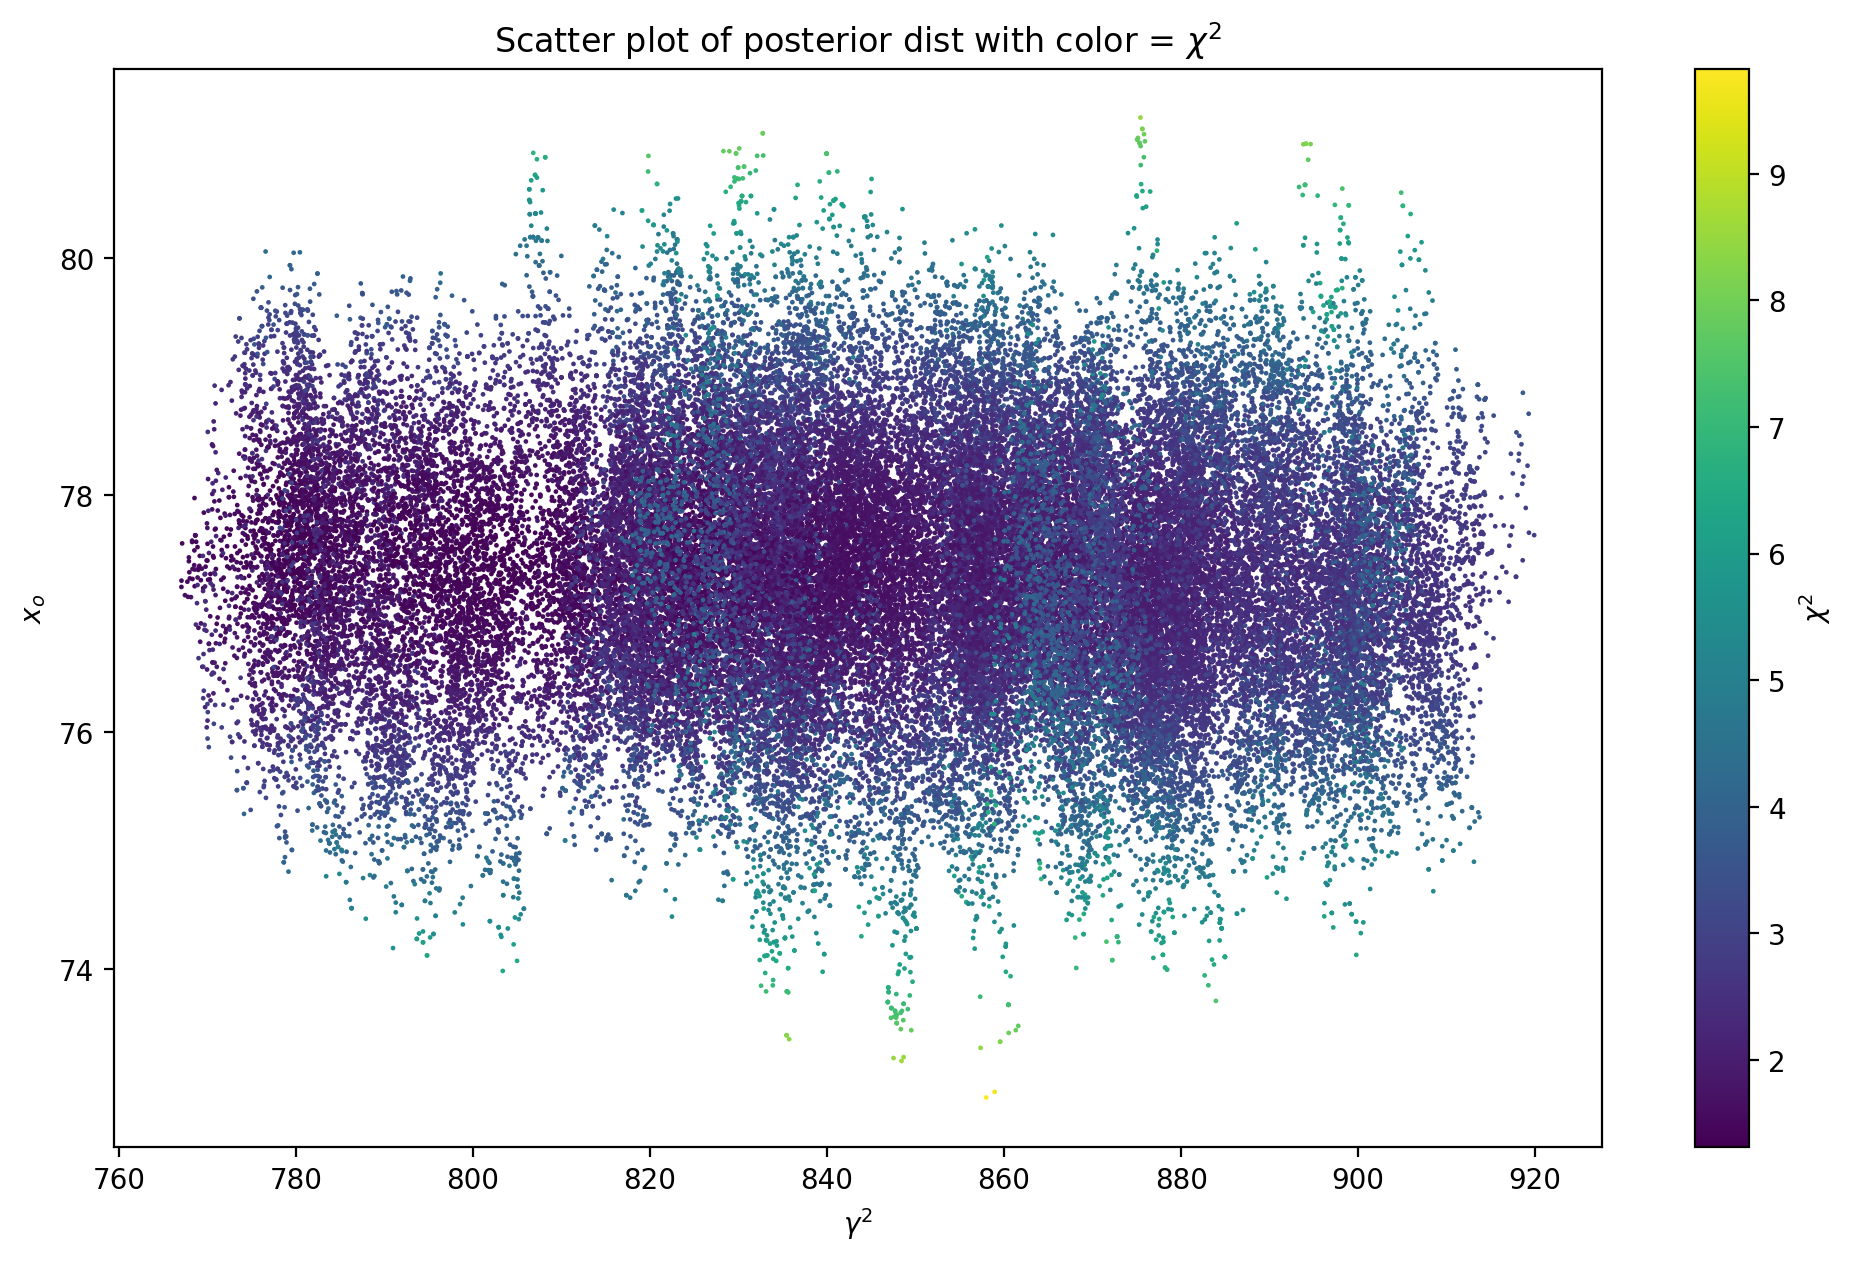

In [23]:
imin = np.argmin(chisq_post)
imax = np.argmax(chisq_post)

plt.figure()
plt.scatter(gammasq_post,x0_post,s=.5,
            c=chisq_post,
            vmin=chisq_post[imin],
            vmax=chisq_post[imax])
plt.colorbar(label='$\chi^2$')
plt.title('Scatter plot of posterior dist with color = $\chi^2$')
plt.xlabel('$\gamma^2$')
plt.ylabel('$x_o$')

Finally, armed with the idea of a confidence interval, I can now do better than taking a single curve of best fit: I can look at the *range* of curves represented by the posterior distribution.

To calculate a 95% confidence interval of best fit, I perform three steps:
1. Calculate the curve represented by a relatively large number of samples from the posterior. Here I take 200 points spaced by 50 steps, to avoid any correlation between them so that the sample is as fair as possible.
1. Calculate the 2.5th and 97.5th percentiles, using the `quantile()` function from `numpy` as above.
1. Use the `fill_between()` function from `matplotlib` to plot the range between these percentiles: that is, the 95% confidence interval for the “true“ value at each point on the graph.

**The code below uses these steps to plot a curve showing the confidence interval at each point on the $x$ axis, together with the observed experimental data.**

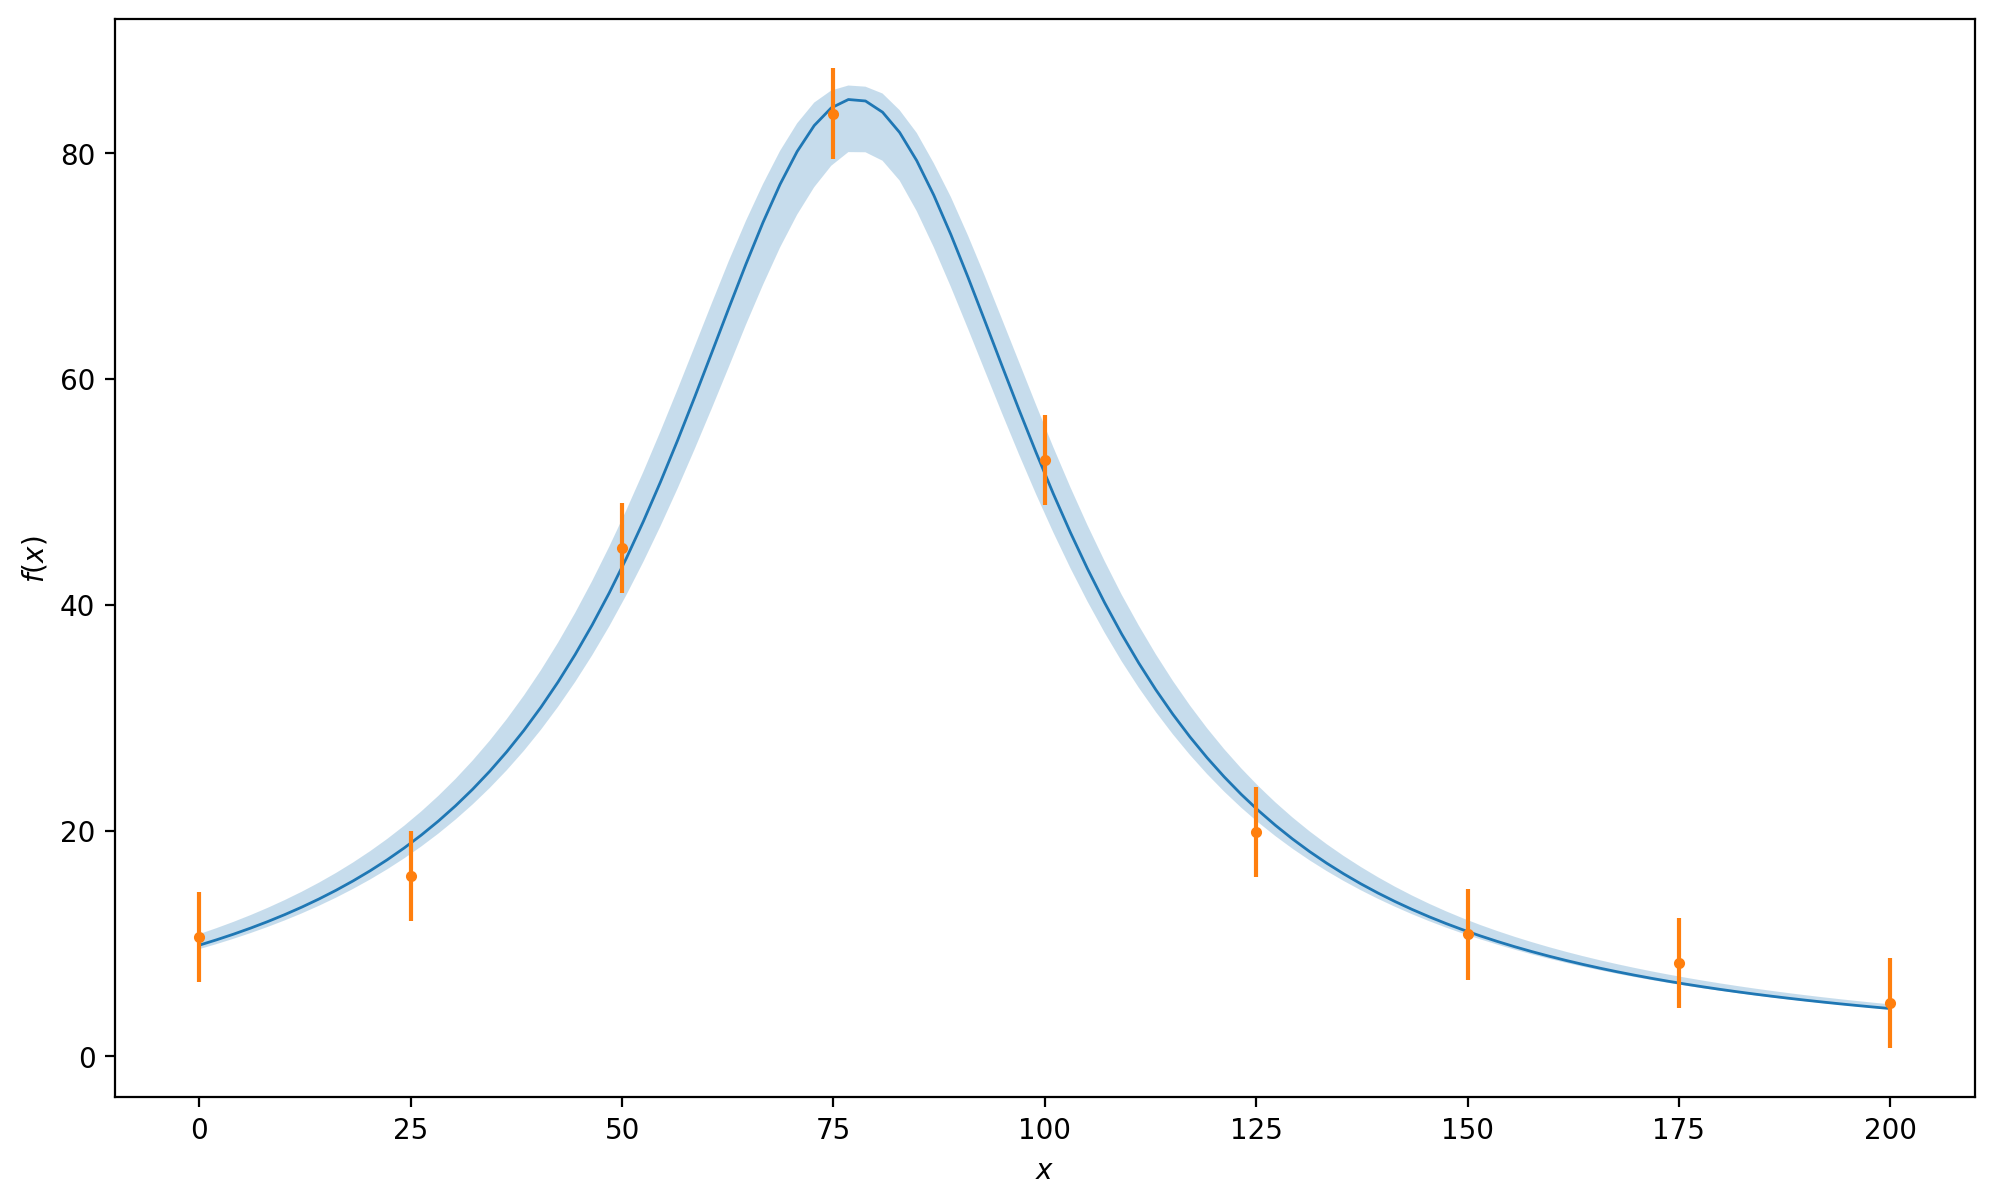

In [24]:
# Take random curves from the posterior
n_curves = 200
spacing = 50

models = np.array([lorentzian(xplot, (A_post[i*spacing], x0_post[i*spacing], gammasq_post[i*spacing]))
                   for i in range(n_curves)])

model_lowerq = np.quantile(models, 0.025, axis=0)
model_upperq = np.quantile(models, 0.975, axis=0)

imin = np.argmin(chisq_post)
A_best = A_post[imin]
x0_best = x0_post[imin]
gammasq_best = gammasq_post[imin]

plt.figure()
plt.fill_between(xplot, model_lowerq, model_upperq, alpha=0.25)
# alpha = transparency: 0 is transparent, 1 is opaque
plt.plot(xplot, lorentzian(xplot, (A_best, x0_best, gammasq_best)), linewidth=1)
plt.errorbar(data_x, data_y, fmt='.', yerr=data_y_err)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

## not too sure if this is what it is supposed to look like